In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
import scipy.interpolate
import sys
import functools
import time as pytime
import os
import math
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [2]:
from backend import jnp, conditional_decorator, jit, use_jax, fori_loop, put, cross, dot, sign, presfun, iotafun
from backend import get_needed_derivatives, unpack_x, rms, jacfwd, jacrev

from zernike import ZernikeTransform, get_zern_basis_idx_dense, get_double_four_basis_idx_dense, axis_posn, symmetric_x
from zernike import fringe_to_lm, lm_to_fringe, zern, zern_radial, fourzern, eval_double_fourier
from init_guess import get_initial_guess_scale_bdry
from boundary_conditions import compute_bc_err_four, compute_bc_err_RZ, compute_lambda_err, format_bdry
from plotting import plot_IC, plot_fb_err, plot_coord_surfaces, plot_coeffs
from field_components import compute_coordinate_derivatives, compute_jacobian, compute_covariant_basis
from field_components import compute_B_field, compute_J_field, compute_contravariant_basis
from objective_funs import compute_force_error_nodes, compute_force_error_RphiZ, compute_force_error_RddotZddot, get_equil_obj_fun
from nodes import get_nodes_pattern
from input_output import read_input, output_to_file
from gfile_helpers import read_gfile, write_gfile, plot_gfile
from zernike import four, zern, zern_radial, zern_azimuthal, four_toroidal, zern_radial_r, zern_radial_rr, zern_radial_rrr
from zernike import zern_azimuthal, zern_azimuthal_v, zern_azimuthal_vv, zern_azimuthal_vvv
from zernike import four_toroidal, four_toroidal_z
from scipy.special import factorial

Using JAX float64


/home/fouriest/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot
import matplotlib
from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 10
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (6,4)
rcParams['figure.dpi'] = 141
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'small'
rcParams['axes.titlesize'] = 'medium'
rcParams['lines.linewidth'] = 1
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'x-small'
rcParams['ytick.labelsize'] = 'x-small'
# rcParams['text.usetex']=True
color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
# rcParams['axes.prop_cycle'] =  color_cycle
rcParams['axes.prop_cycle'] =  color_cycle + dash_cycle

labelsize=10
ticksize=8

In [5]:
import jax
jax.devices()

[CpuDevice(id=0)]

In [27]:
m = np.arange(-1,2)
v = np.linspace(0,np.pi,10)

# zern_azimuthal_v(v,m)
double_fourier_basis(v,v,m,m+1,1)

DeviceArray([[ 0.00000000e+00,  1.00000000e+00,  1.00000000e+00],
             [ 3.42020143e-01,  9.39692621e-01,  7.19846310e-01],
             [ 6.42787610e-01,  7.66044443e-01,  1.33022222e-01],
             [ 8.66025404e-01,  5.00000000e-01, -2.50000000e-01],
             [ 9.84807753e-01,  1.73648178e-01, -1.63175911e-01],
             [ 9.84807753e-01, -1.73648178e-01,  1.63175911e-01],
             [ 8.66025404e-01, -5.00000000e-01,  2.50000000e-01],
             [ 6.42787610e-01, -7.66044443e-01, -1.33022222e-01],
             [ 3.42020143e-01, -9.39692621e-01, -7.19846310e-01],
             [ 1.22464680e-16, -1.00000000e+00, -1.00000000e+00]],            dtype=float64)

In [7]:
inputs = read_input('./benchmarks/DESC/DSHAPE.input')
print(inputs)
# inputs['Mpol'] = np.array([6,8,10])
# inputs['Ntor'] = np.array([0,2,4])
# inputs['bdry_ratio'] = np.array([0,.5,1])
# inputs['ftol'] = [1e-6]
# inputs['xtol'] = [1e-6]
# inputs['gtol'] = [1e-6]
# inputs['max_nfev'] = [50]

{'stell_sym': True, 'NFP': 1, 'Psi_total': 1.0, 'Mpol': array([12]), 'Ntor': array([0]), 'Mnodes': array([18]), 'Nnodes': array([0]), 'bdry_ratio': array([1.]), 'pres_ratio': array([1.]), 'zeta_ratio': array([1.]), 'errr_ratio': array([1.]), 'errr_mode': 'force', 'bdry_mode': 'spectral', 'node_mode': 'cheb2', 'presfun_params': array([ 1600.,     0., -3200.,     0.,  1600.]), 'iotafun_params': array([ 1.  ,  0.  , -0.67]), 'axis': array([[0.  , 3.65, 0.  ],
       [0.  , 0.  , 0.  ]]), 'bdry': array([[ 0.   ,  0.   ,  3.51 ,  0.   ],
       [ 1.   ,  0.   ,  1.   ,  0.   ],
       [ 2.   ,  0.   ,  0.106,  0.   ],
       [-1.   ,  0.   ,  0.   ,  1.47 ],
       [-2.   ,  0.   ,  0.   , -0.16 ]])}


precomputing Fourier-Zernike basis
computing initial guess


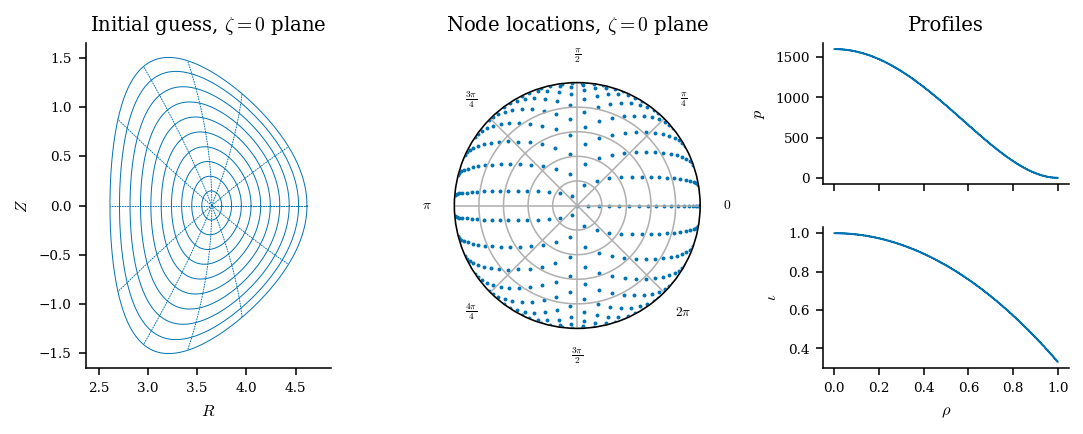

In [89]:
stell_sym      = inputs['stell_sym']
M              = inputs['Mpol'][-1]
N              = inputs['Ntor'][-1]
Mnodes         = inputs['Mnodes'][-1]
Nnodes         = inputs['Nnodes'][-1]
NFP            = inputs['NFP']
Psi_total      = inputs['Psi_total']
error_mode     = inputs['errr_mode']
bdry_mode      = inputs['bdry_mode']
node_mode      = inputs['node_mode']
bdry_ratio     = inputs['bdry_ratio']
pres_ratio     = inputs['pres_ratio']
zeta_ratio     = inputs['zeta_ratio']
errr_ratio     = inputs['errr_ratio']
presfun_params = inputs['presfun_params']
iotafun_params = inputs['iotafun_params']
axis           = inputs['axis']  # TODO: use this for computing initial guess
bdry           = inputs['bdry']

cP = presfun_params
cI = iotafun_params
M=10
N=4
bdry_mode_in = bdry_mode

if error_mode == 'force':
    equil_fun = compute_force_error_nodes
elif error_mode == 'accel':
    equil_fun = compute_accel_error_spectral
if bdry_mode == 'real':
    bdry_fun = compute_bc_err_RZ
elif bdry_mode == 'spectral':
    bdry_fun = compute_bc_err_four

# weights
weights = {'F':1e6,     # force balance error
           'B':1e4,     # error in bdry
           'L':1e4}     # error in sum lambda_mn



bdry_poloidal, bdry_toroidal, bdryR, bdryZ = format_bdry(M, N, NFP, bdry, bdry_mode_in, bdry_mode)
nodes,volumes = get_nodes(Mnodes,Nnodes,NFP,surfs=node_mode,nr=25,nt=25,nz=0)

# interpolator
print('precomputing Fourier-Zernike basis')
derivatives = get_needed_derivatives('all')
zern_idx = get_zern_basis_idx_dense(M,N)
lambda_idx = get_double_four_basis_idx_dense(M,N)
zernt = ZernikeTransform(nodes,zern_idx,NFP,derivatives)

if stell_sym:
    sym_mat = symmetric_x(M,N)
else:
    sym_mat = np.eye(2*len(zern_idx) + len(lambda_idx))


# initial guess
print('computing initial guess')
cR_init,cZ_init = get_initial_guess_scale_bdry(axis,bdry,zern_idx,NFP,mode=bdry_mode,rcond=1e-6)
cL_init = np.zeros(len(lambda_idx))
x_init = jnp.concatenate([cR_init,cZ_init,cL_init])
x_init = jnp.matmul(sym_mat.T,x_init)

x = x_init




args = (presfun_params,iotafun_params,Psi_total,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,
        NFP,zernt,nodes,volumes,zern_idx,lambda_idx,weights,sym_mat,equil_fun,bdry_fun)
static_args = (6,7,8,9,10,11,12,13,16,17)




fig, ax = plot_IC(cR_init, cZ_init, zern_idx, NFP, nodes, presfun_params, iotafun_params)

In [4]:
zern_idx = get_zern_basis_idx_dense(2,1)
nodes,volumes = get_nodes_pattern(3,0,1,surfs='cheb1')
rho = nodes[0]
vartheta = nodes[1]
zeta = nodes[2]
zern_idx.shape

(27, 3)

In [33]:


def get_jacobi_coeffs_exact(l,m):
    
    l = np.atleast_1d(l)
    m = np.atleast_1d(abs(m))
    lmax = np.max(l)
    npoly = len(l)
    coeffs = np.zeros((npoly,lmax+1))
    for ii, (ll,mm) in enumerate(zip(l,m)):
        if (ll-mm)%2 != 0:
            continue
        for s in range(mm,ll+1,2):
            coeffs[ii,s] = (-1)**((ll-s)/2)*factorial((ll+s)/2,exact=True)/(
                factorial((ll-s)/2,exact=True)*factorial((s+mm)/2,exact=True)*factorial((s-mm)/2,exact=True))
    return np.fliplr(coeffs)

In [34]:
coeffs = get_jacobi_coeffs(zern_idx[:,0],zern_idx[:,1])
coeffs_exact = get_jacobi_coeffs_exact(zern_idx[:,0],zern_idx[:,1])
coeffs.shape

(27, 5)

In [62]:
def get_jacobi_coeffs(l,m):
    """Computes coefficients for Jacobi polynomials used in Zernike basis
    
    Args:
        l (ndarray of int, shape(N,)): radial mode numbers
        m (ndarray of int, shape(N,)): azimuthal mode numbers
    
    Returns:
        jacobi_coeffs (ndarray, shape(N,max(l)+1)): matrix of polynomial coefficients in
            order of descending powers. Each row contains the coeffs for a given l,m.
    """
    
    l = np.atleast_1d(l)
    m = np.atleast_1d(abs(m))
    lmax = np.max(l)
    npoly = len(l)
    coeffs = np.zeros((npoly,lmax+1))
    for ii, (ll,mm) in enumerate(zip(l,m)):
        if (ll-mm)%2 != 0:
            continue
        for s in range(mm,ll+1,2):
            coeffs[ii,s] = (-1)**((ll-s)/2)*factorial((ll+s)/2)/(
                factorial((ll-s)/2)*factorial((s+mm)/2)*factorial((s-mm)/2))
    return np.fliplr(coeffs)

def polyder_vec(p,m=1,pad=True):
    """Vectorized version of polyder for differentiating multiple polynomials of the same degree
    
    Args:
        p (ndarray, shape(N,M)): polynomial coefficients. Each row is 1 polynomial, in descending powers of x,
            each column is a power of x
        m (int >=0): order of derivative
        pad (bool): whether to pad output with zeros to be the same shape as input
            
    Returns:
        der (ndarray, shape(N,M) if pad, else shape(N,M-m)): polynomial coefficients for derivative in descending order
    
    """
    m = int(m)
    if m < 0:
        raise ValueError("Order of derivative must be positive")

    p = np.atleast_2d(p)
    n = p.shape[1] - 1 # order of polynomials
    y = p[:,:-1] * np.arange(n, 0, -1)
    if pad:
        y = np.pad(y,((0,0),(1,0)))
    if m == 0:
        val = p
    else:
        val = polyder_vec(y, m - 1,pad)
    return val


def polyval_vec(p, x):
    """Evaluate a polynomial at specific values, 
    vectorized for evaluating multiple polynomials of the same degree.

    Parameters:
        p (ndarray, shape(N,M)): Array of coefficient for N polynomials of order M. 
            Each row is one polynomial, given in descending powers of x. 
        x (array-like, len(K,)): A number, or 1d array of numbers at
            which to evaluate p. If greater than 1d it is flattened.
       
    Returns:
        y (ndarray, shape(N,K)): polynomials evaluated at x.
            Each row corresponds to a polynomial, each column to a value of x

    Notes:
        Horner's scheme is used to evaluate the polynomial. Even so,
        for polynomials of high degree the values may be inaccurate due to
        rounding errors. Use carefully.

    """
    p = np.atleast_2d(p)
    npoly = p.shape[0]
    order = p.shape[1]
    x = np.asarray(x).flatten()
    nx = len(x)
    y = np.zeros((npoly,nx))
    for i in range(order):
        y = y * x + p[:,i][:,np.newaxis]
    return y

In [7]:
fourzern(rho,vartheta,zeta,1,1,1,1,0,0,0).shape

(16, 1)

In [71]:
nodes.shape

(3, 16)

In [9]:
r = np.linspace(0,1,5)

np.hstack([fourzern(r,r,r,1,1,1,1,0,0,0) for i in range(9)]).shape

(5, 9)

In [60]:
a = np.arange(12).reshape((3,4))
x = np.linspace(0,1,5)
# np.atleast_2d(a).shape
#np.pad(a,((0,0),(1,0)))
print(a)
polyval_vec(a,x)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]


array([[ 3.    ,  7.    , 11.    ],
       [ 3.5625,  8.875 , 14.1875],
       [ 4.25  , 11.75  , 19.25  ],
       [ 5.0625, 16.    , 26.9375],
       [ 6.    , 22.    , 38.    ]])

In [158]:
np.max(abs(coeffs-coeffs_exact))

0.000244140625

In [159]:
vand = np.vander(rho,len(coeffs))
print(vand.shape)
print(vand.dtype)

(961, 37)
float64


In [244]:
%%timeit
coeffs = get_jacobi_coeffs(zern_idx[:,0],zern_idx[:,1])
vand = np.vander(rho,len(coeffs))
# interp2 = (vand[:,:,np.newaxis]*coeffs[np.newaxis,:,:]).sum(axis=1)
interp3 = np.sort(vand[:,:,np.newaxis]*coeffs[np.newaxis,:,:],axis=1).sum(axis=1)

1.47 s ± 13.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [64]:
np.finfo(np.double)

finfo(resolution=1e-15, min=-1.7976931348623157e+308, max=1.7976931348623157e+308, dtype=float64)

In [160]:
temp = (vand[:,:,np.newaxis]*coeffs_exact[np.newaxis,:,:])
print(temp.dtype)
interp1 = jnp.stack([zern_radial(rho,lmn[0],lmn[1]) for lmn in zern_idx]).T
interp2 = temp.sum(axis=1)
interp3 = np.sort(temp,axis=1).sum(axis=1)
interp4 = np.zeros_like(interp1)
for i in range(temp.shape[0]):
    for j in range(temp.shape[2]):
        interp4[i,j] = math.fsum(temp[i,:,j])
    

float64


In [161]:
interp2.dtype

dtype('float64')

In [162]:
print(np.where(abs(interp1)>1)[0].size)
print(np.max(abs(interp1)))
print(np.where(abs(interp2)>1)[0].size)
print(np.max(abs(interp2)))
print(np.where(abs(interp3)>1)[0].size)
print(np.max(abs(interp3)))
print(np.where(abs(interp4)>1)[0].size)
print(np.max(abs(interp4)))
print(interp.size)

671
1.00006103515625
0
1.0
0
1.0
793
1.0000303983688354
346921


In [101]:
(np.where(abs(interp2[np.where(rho==1)]) > 1)[0].size)/(np.where(rho==1)[0].size*len(zern_idx))

0.2767950052029136

In [98]:
np.where(rho==1)[0].size

61

In [87]:
ii = 940
print(zern_idx[ii])
print(coeffs_exact[:,ii])

[50 10  0]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.71292122e+13  0.00000000e+00
 -5.65550547e+14  0.00000000e+00  3.17977910e+15  0.00000000e+00
 -1.11292268e+16  0.00000000e+00  2.71718889e+16  0.00000000e+00
 -4.91456774e+16  0.00000000e+00  6.82578852e+16  0.00000000e+00
 -7.44631475e+16  0.00000000e+00  6.47223288e+16  0.00000000e+00
 -4.52028963e+16  0.00000000e+00  2.54679733e+16  0.00000000e+00
 -1.15763515e+16  0.00000000e+00  4.22982074e+15  0.00000000e+00
 -1.23298418e+15  0.00000000e+00  2.83253123e+14  0.00000000e+00
 -5.03561108e+13  0.00000000e+00  6.74412198e+12  0.00000000e+00
 -6.53409742e+11  0.00000000e+00  4.29006396e+10  0.00000000e+00
 -1.69344630e+09  0.00000000e+00  3.00450150e+07  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+

In [163]:
print(np.max(abs(interp3 - interp1)))
print(np.max(abs(interp3 - interp2)))
print(np.max(abs(interp1 - interp2)))
print(np.max(abs(interp1 - interp4)))


0.0006897441093050016
0.0005393168495970713
0.0004867360076266092
0.00020963041238908353


In [203]:
np.where(abs(interp - interp2)>1e-10)

(array([ 16,  17,  18, ..., 360, 360, 360]),
 array([600, 600, 600, ..., 617, 618, 619]))

In [56]:
np.max(coeffs)

1.583414741574766e+21

In [164]:
def fringe_to_lm(idx):
    """Convert single Fringe index to (l,m) double index.
    """
    M = (np.ceil(np.sqrt(idx+1)) - 1)
    m = idx - M**2 - M
    l = 2*M - np.abs(m)
    return int(l), int(m)

def get_zern_basis_idx_dense(M,N):
    num_lm_modes = (M+1)**2
    num_four = 2*N+1
    return np.array([(*fringe_to_lm(i),n-N) for i in range(num_lm_modes) for n in range(num_four)])


In [183]:
a = np.arange(5)[np.newaxis,:]
b = np.arange(3)[:,np.newaxis]
(b*a).shape

(3, 5)

16306

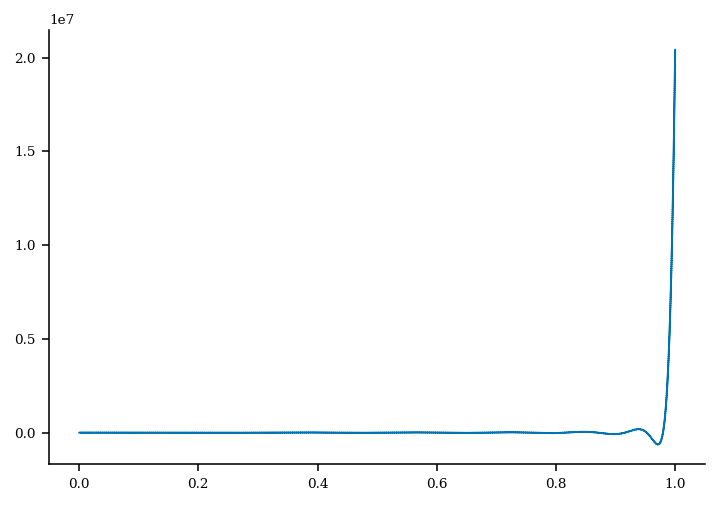

In [134]:
x = np.linspace(0,1,100000)
y = zern_radial_rrr(x,31,5)
plt.plot(x,y)

In [124]:
np.linalg.svd(interp[:,:10],compute_uv=False)

array([6.09236452e+01, 3.00070678e+01, 1.78253760e+01, 2.38373443e+00,
       8.58597884e-02, 3.98327505e-15, 2.10602387e-15, 8.28255565e-16,
       7.12240148e-17, 1.85966821e-31])

In [90]:
cR,cZ,cL = unpack_x(jnp.matmul(sym_mat,x),len(zern_idx))
errRf,errZf = equil_fun(cR,cZ,cP,cI,Psi_total,pres_ratio,zeta_ratio,zernt,nodes,volumes)
errRb,errZb = bdry_fun(cR,cZ,cL,bdry_ratio,zern_idx,lambda_idx,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,NFP)

In [91]:
equil_fun_jit = jit(equil_fun, static_argnums=(7,8))
bdry_fun_jit = jit(bdry_fun, static_argnums=(6,7,8,9,10))

In [92]:
%time errRf,errZf = equil_fun_jit(cR,cZ,cP,cI,Psi_total,pres_ratio,zeta_ratio,zernt,nodes,volumes)
%time errRb,errZb = bdry_fun_jit(cR,cZ,cL,bdry_ratio,zern_idx,lambda_idx,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,NFP)

CPU times: user 5.18 s, sys: 17.5 ms, total: 5.2 s
Wall time: 5.16 s
CPU times: user 25min 29s, sys: 1.56 s, total: 25min 30s
Wall time: 25min 29s


In [93]:
%%timeit
"""non jit obj"""
errRf,errZf = equil_fun(cR,cZ,cP,cI,Psi_total,pres_ratio,zeta_ratio,zernt,nodes,volumes)

157 ms ± 5.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [94]:
%%timeit
"""jit obj"""
errRf,errZf = equil_fun_jit(cR,cZ,cP,cI,Psi_total,pres_ratio,zeta_ratio,zernt,nodes,volumes)

3.6 ms ± 162 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [95]:
%%timeit
"""non jit bdry"""
errRb,errZb = bdry_fun(cR,cZ,cL,bdry_ratio,zern_idx,lambda_idx,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,NFP)

1.05 s ± 14.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [96]:
%%timeit
"""jit bdry"""
errRb,errZb = bdry_fun_jit(cR,cZ,cL,bdry_ratio,zern_idx,lambda_idx,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,NFP)

160 ms ± 2.2 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [76]:
foo = jax.xla_computation(bdry_fun, static_argnums=(6,7,8,9,10))

In [77]:
bar = foo(cR,cZ,cL,bdry_ratio,zern_idx,lambda_idx,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,NFP)

In [80]:
with open('bdry_xla.txt','w+') as f:
    f.write(bar.as_hlo_text())

In [75]:
with open('bdry_jaxpr.txt','w+') as f:
    f.write(str(bar))

In [67]:
dFjac = jacfwd(compute_force_error_RddotZddot,argnums=(0,1))
dFtup = dFjac(cR,cZ,zernt,nodes,presfun_params,iotafun_params,Psi_total,volumes)
dF = np.vstack([np.hstack(dFtup[0]),np.hstack(dFtup[1])])

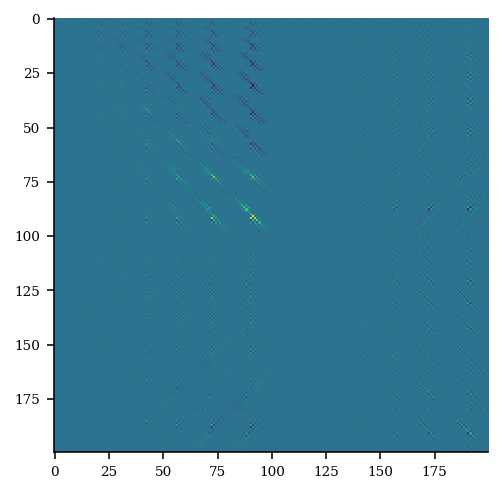

In [64]:
plt.imshow(dF)

In [70]:
rms(dFtup[1][1] - dFtup[1][1].T)

DeviceArray(0.19756151, dtype=float64)

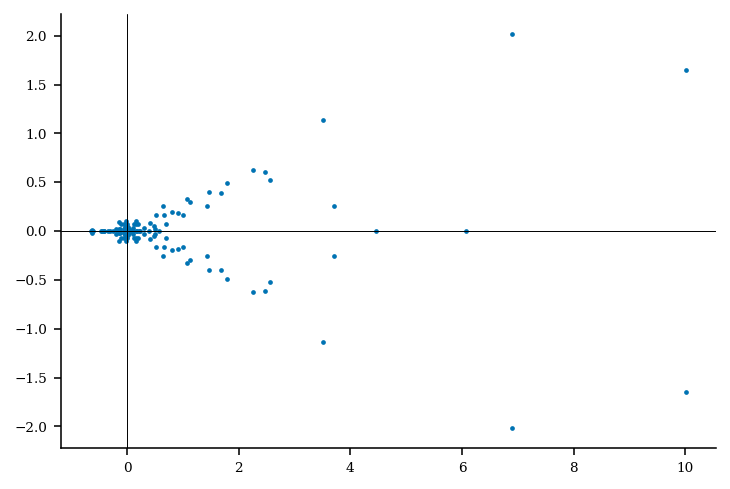

In [66]:
eigs = np.linalg.eig(dF)[0]
plt.scatter(eigs.real,eigs.imag,s=2)
plt.axvline(0,c='k',lw=.5)
plt.axhline(0,c='k',lw=.5)

In [9]:
def lstsq_obj(x,presfun_params,iotafun_params,Psi_total,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,
              NFP,zernt,nodes,volumes,zern_idx,lambda_idx,weights,sym_mat,equil_fun,bdry_fun):
    
    cR,cZ,cL = unpack_x(jnp.matmul(sym_mat,x),len(zern_idx))
    errRf,errZf = equil_fun(cR,cZ,zernt,nodes,presfun_params,iotafun_params,Psi_total,volumes)
    errRb,errZb = bdry_fun(cR,cZ,cL,zern_idx,lambda_idx,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,NFP)
    errL0 = compute_lambda_err(cL,lambda_idx,NFP)
    # divide through by size of the array so weighting isn't thrown off by more points
    loss = jnp.concatenate([weights['F']*errRf.flatten()/errRf.size,   
                            weights['F']*errZf.flatten()/errZf.size,
                            weights['B']*errRb.flatten()/errRb.size,
                            weights['B']*errZb.flatten()/errZb.size,
                            weights['L']*errL0.flatten()/errL0.size])
    return loss

def callback(x,presfun_params,iotafun_params,Psi_total,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,
             NFP,zernt,nodes,volumes,zern_idx,lambda_idx,weights,sym_mat,equil_fun,bdry_fun):
    
    cR,cZ,cL = unpack_x(jnp.matmul(sym_mat,x),len(zern_idx))
    errRf,errZf = equil_fun(cR,cZ,zernt,nodes,presfun_params,iotafun_params,Psi_total,volumes)
    errRb,errZb = bdry_fun(cR,cZ,cL,zern_idx,lambda_idx,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,NFP)
    errL0 = compute_lambda_err(cL,lambda_idx,NFP)
    
    errRf_rms = rms(errRf)
    errZf_rms = rms(errZf)
    errRb_rms = rms(errRb)
    errZb_rms = rms(errZb)
    errL0_rms = rms(errL0)
    
    loss = np.concatenate([weights['F']*errRf.flatten(),
                           weights['F']*errZf.flatten(),
                           weights['B']*errRb.flatten(),
                           weights['B']*errZb.flatten(),
                           weights['L']*errL0.flatten()])
    loss_rms = jnp.sum(loss**2)
    print('Weighted Loss: {:10.3e}  errRf: {:10.3e}  errZf: {:10.3e}  errRb: {:10.3e}  errZb: {:10.3e}  errL0: {:10.3e}'.format(
    loss_rms,errRf_rms,errZf_rms,errRb_rms,errZb_rms,errL0_rms))

jac = jacfwd(lstsq_obj,argnums=0)
press_jac = jacfwd(lstsq_obj,argnums=1)
iota_jac = jacfwd(lstsq_obj,argnums=2)
psi_jac = jacfwd(lstsq_obj,argnums=3)
Rb_jac = jacfwd(lstsq_obj,argnums=4)
Zb_jac = jacfwd(lstsq_obj,argnums=5)



compiling
compiled objective
compiled jacobian


In [48]:
%%timeit
foo = lstsq_obj_jit(x_init,*args).block_until_ready() 

10.7 ms ± 132 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [47]:
jnp.asarray

<function jax.numpy.lax_numpy.asarray(a, dtype=None, order=None)>

In [49]:
%%timeit
foo = lstsq_obj(x_init,*args)

203 ms ± 9.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
%%timeit
foo = jac_jit(x_init,*args).block_until_ready() 

365 ms ± 42.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
%%timeit
foo = jac(x_init,*args)

677 ms ± 16.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
Jf = jac(x,*args)
Jp = press_jac(x,*args)
Ji = iota_jac(x,*args)
Js = psi_jac(x,*args)
JR = Rb_jac(x,*args)
JZ = Zb_jac(x,*args)

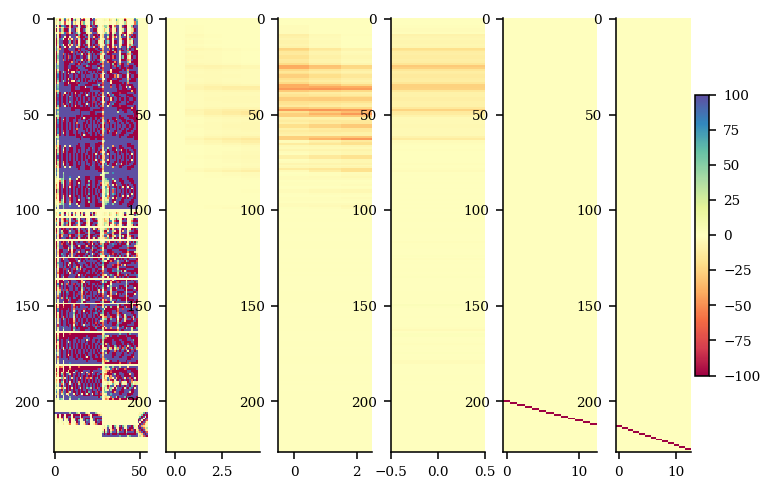

In [19]:
fig, ax = plt.subplots(1,6)
vmin = -100
vmax = 100
cmap = 'Spectral'
aspect='auto'
im = ax[0].imshow(np.atleast_2d(Jf),vmin=vmin,vmax=vmax,cmap=cmap, aspect=aspect)
im = ax[1].imshow(np.atleast_2d(Jp*1e3),vmin=vmin,vmax=vmax,cmap=cmap, aspect=aspect)
im = ax[2].imshow(np.atleast_2d(Ji),vmin=vmin,vmax=vmax,cmap=cmap, aspect=aspect)
im = ax[3].imshow(np.atleast_2d(Js).T,vmin=vmin,vmax=vmax,cmap=cmap, aspect=aspect)
im = ax[4].imshow(np.atleast_2d(JR),vmin=vmin,vmax=vmax,cmap=cmap, aspect=aspect)
im = ax[5].imshow(np.atleast_2d(JZ),vmin=vmin,vmax=vmax,cmap=cmap, aspect=aspect)
plt.colorbar(im)

In [31]:
Jp

DeviceArray([1.39271396e+04, 1.39121360e+04, 1.38676998e+04, ...,
             2.63516670e+09, 2.54162655e+09, 2.51219179e+09],            dtype=float64)

`xtol` termination condition is satisfied.
Function evaluations 454, initial cost 1.2061e+07, final cost 3.8211e-24, first-order optimality 7.93e-08.
Initial
Weighted Loss:  1.583e+11  errRf:  4.410e-02  errZf:  3.020e-03  errRb:  5.559e-06  errZb:  8.086e-07  errL0:  0.000e+00
Final
Weighted Loss:  2.385e-20  errRf:  1.487e-17  errZf:  7.325e-18  errRb:  8.727e-16  errZb:  2.845e-16  errL0:  0.000e+00


initial: R0 = 3.941, Z0 = 0.000
final:   R0 = 3.909, Z0 = 0.000


Text(0.5, 1.0, 'Solution')

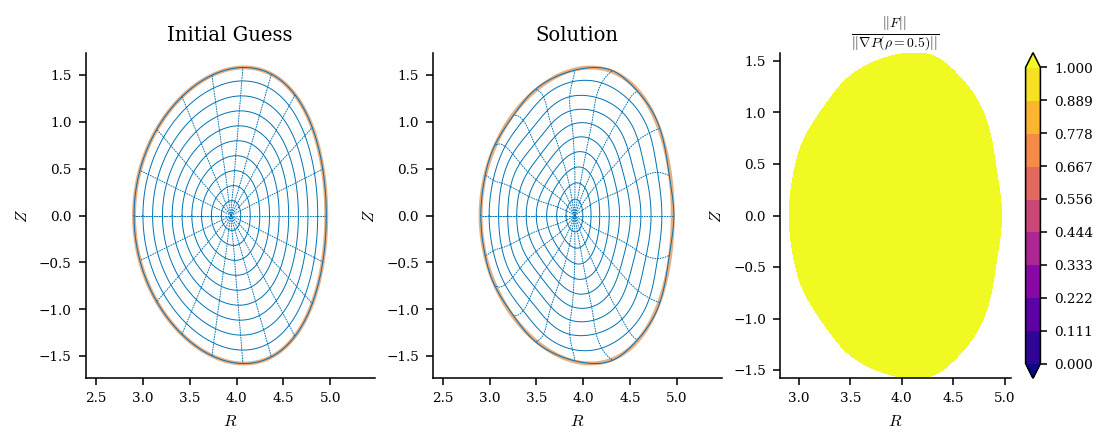

In [40]:
x = out['x']
cR,cZ,cL = unpack_x(jnp.matmul(sym_mat,x),len(zern_idx))
axis_init = axis_posn(cR_init,cZ_init,zern_idx,NFP)
axis_final = axis_posn(cR,cZ,zern_idx,NFP)
print('initial: R0 = {:.3f}, Z0 = {:.3f}'.format(axis_init[0],axis_init[1]))
print('final:   R0 = {:.3f}, Z0 = {:.3f}'.format(axis_final[0],axis_final[1]))

theta = np.linspace(0,2*np.pi,1000)
phi = np.zeros_like(theta)
Rlcfs = eval_double_fourier(bdryR,np.array([bdry_poloidal,bdry_toroidal]).T,NFP,theta,phi)
Zlcfs = eval_double_fourier(bdryZ,np.array([bdry_poloidal,bdry_toroidal]).T,NFP,theta,phi)


fig, ax = plt.subplots(1,3,figsize=(9,3))
plot_coord_surfaces(cR_init,cZ_init,zern_idx,NFP,nr=10,nt=20,ax=ax[0],bdryR=Rlcfs,bdryZ=Zlcfs);
plot_coord_surfaces(cR,cZ,zern_idx,NFP,nr=10,nt=20,ax=ax[1],bdryR=Rlcfs,bdryZ=Zlcfs);
ax[2], im = plot_fb_err(cR,cZ,cL,zern_idx,lambda_idx,NFP,iotafun_params, presfun_params, Psi_total,
                domain='real', normalize='global', ax=ax[2], log=False, cmap='plasma',nlevels=10)
ax[0].set_title('Initial Guess')
ax[1].set_title('Solution')
# plt.colorbar(im,ax=ax[2]);

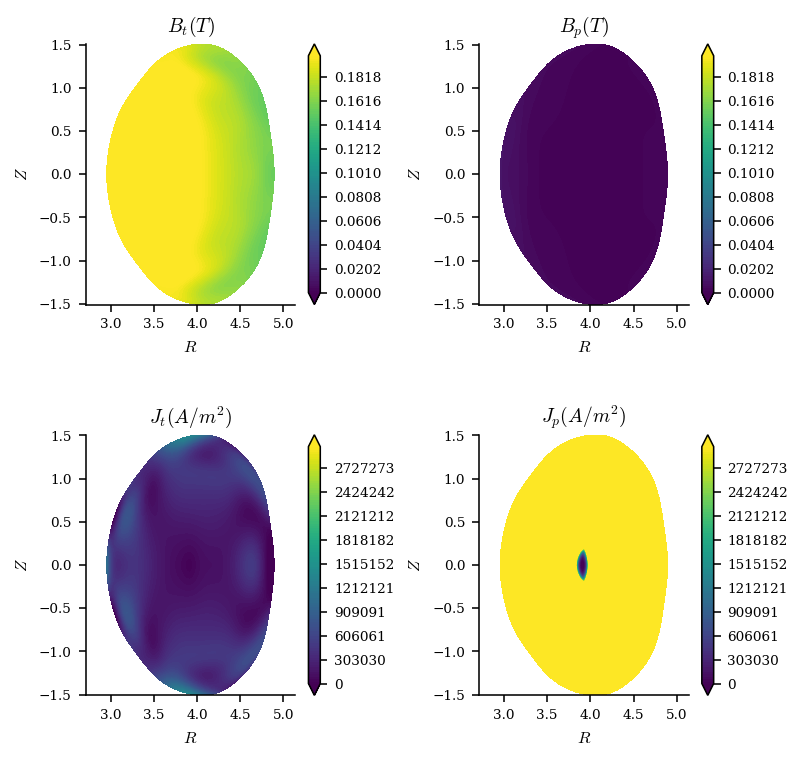

In [42]:
kwargs = {'Blevels':np.linspace(0,.2,100),'Jlevels':np.linspace(0,3e6,100)}
fig, ax = plt.subplots(2,2,figsize=(6,6))
ax = ax.flatten()
cmap = None
domain = 'real'



r = kwargs.get('r',np.linspace(0.01,.95,100))
v = kwargs.get('theta',np.linspace(0,2*np.pi,100))
z = kwargs.get('zeta',0)
rr,vv,zz = np.meshgrid(r,v,z,indexing='ij')
rr = rr.flatten()
vv = vv.flatten()
zz = zz.flatten()

nodes = np.stack([rr,vv,zz])
derivatives = get_needed_derivatives('force')
zernt = ZernikeTransform(nodes,zern_idx,NFP,derivatives)
axn = np.where(rr == 0)[0]
N_nodes = rr.size

coord_der = compute_coordinate_derivatives(cR,cZ,zernt)
cov_basis = compute_covariant_basis(coord_der)
jacobian = compute_jacobian(coord_der,cov_basis)
B_field = compute_B_field(Psi_total, jacobian, nodes, axn, cov_basis, iotafun_params)
J_field = compute_J_field(B_field, jacobian, cov_basis, nodes, axn)

Bt = B_field['B_RphiZ'][1]
Bp = B_field['B_RphiZ'][0]**2 + B_field['B_RphiZ'][2]**2
Jt = J_field['J_RphiZ'][1]
Jp = J_field['J_RphiZ'][0]**2 + J_field['J_RphiZ'][2]**2

sigs = {'$B_t (T)$':Bt,
        '$B_p (T)$':Bp,
        '$J_t (A/m^2)$':Jt,
        '$J_p (A/m^2)$':Jp}

Blevels = kwargs.get('Blevels',100)
Jlevels = kwargs.get('Jlevels',100)
levels = [Blevels,Blevels,Jlevels,Jlevels]
if domain == 'real':
    R = zernt.transform(cR,0,0,0)
    Z = zernt.transform(cZ,0,0,0)
    for i, (label,val) in enumerate(sigs.items()):
        im = ax[i].tricontourf(R,Z,val, cmap=cmap, extend='both', levels=levels[i])

        ax[i].set_xlabel(r'$R$')
        ax[i].set_ylabel(r'$Z$')
        ax[i].axis('equal')
        ax[i].set_aspect('equal')
        ax[i].set_title(label)
        plt.colorbar(im,ax=ax[i])

elif domain == 'sfl':
    for i, (label,val) in enumerate(sigs.items()):
        im = ax[i].tricontourf(vv,rr,val, cmap=cmap, extend='both', levels=levels[i])
        ax[i].set_xticks([0,np.pi/2,np.pi,3/2*np.pi,2*np.pi])
        ax[i].set_xticklabels(['$0$',r'$\frac{\pi}{2}$',r'$\pi$',r'$\frac{3\pi}{2}$', r'$2\pi$'])
        ax[i].set_xlabel(r'$\theta$')
        ax[i].set_ylabel(r'$\rho$')
        ax[i].set_title(label)
        plt.colorbar(im,ax=ax[i])

plt.subplots_adjust(wspace=.5, hspace=.5)

# I/O stuff

In [53]:
filename = 'test'




In [54]:
s = read_desc('test')

In [57]:
import h5py

In [108]:
write_desc_h5('desc_test.h5',s)

In [97]:
f['equilibrium/zern_idx'].attrs.create('column_labels',['l','m','n'])

In [104]:
f['equilibrium/zern_idx'].attrs['column_labels']

array(['l', 'm', 'n'], dtype=object)

In [107]:
g.close()
f.close()

In [75]:
g = h5py.File('desc_test.h5','r')

In [79]:
a = np.array(g['equilibrium']['zern_idx'])

In [80]:
a

array([[ 0,  0, -6],
       [ 0,  0, -5],
       [ 0,  0, -4],
       ...,
       [18, 18,  4],
       [18, 18,  5],
       [18, 18,  6]])

# Axis stuff

In [52]:
cR = cR_init
cZ = cZ_init
cL = cL_init

N_nodes = nodes[0].size
r = nodes[0]
axn = jnp.where(r == 0)[0]
# value of r one step out from axis
r1 = np.min(r[r != 0])
r1idx = np.where(r == r1)[0]

pres = presfun(r,0,presfun_params)
presr = presfun(r,1, presfun_params)

# compute coordinates, fields etc.
coord_der = compute_coordinate_derivatives(cR,cZ,zernt)
cov_basis = compute_covariant_basis(coord_der)
jacobian = compute_jacobian(coord_der,cov_basis)
B_field = compute_B_field(Psi_total, jacobian, nodes, axn, cov_basis, iotafun_params)
J_field = compute_J_field(B_field, jacobian, nodes, axn)
con_basis = compute_contravariant_basis(coord_der, cov_basis, jacobian, nodes, axn)

# helical basis vector
beta = B_field['B^zeta']*con_basis['e^theta'] - B_field['B^theta']*con_basis['e^zeta']

# force balance error in radial and helical direction
Frho = (J_field['J^theta']*B_field['B^zeta'] - J_field['J^zeta']*B_field['B^theta']) - presr
Fbeta = J_field['J^rho']

radial  = jnp.sqrt(con_basis['g^rr']) * jnp.sign(dot(con_basis['e^rho'],cov_basis['e_rho'],0));
helical = jnp.sqrt(con_basis['g^vv']*B_field['B^zeta']**2 + con_basis['g^zz']*B_field['B^theta']**2 \
               - 2*con_basis['g^vz']*B_field['B^theta']*B_field['B^zeta']) * sign(
    dot(beta,cov_basis['e_theta'],0))*sign(dot(beta,cov_basis['e_zeta'],0));
put(helical,axn,jnp.sqrt(con_basis['g^vv'][axn]*B_field['B^zeta'][axn]**2) * sign(B_field['B^zeta'][axn]))

F_err = jnp.concatenate([Frho*radial,Fbeta*helical])


# force balance error in R,phi,Z
# F_err = Frho*con_basis['grad_rho'] + Fbeta*beta

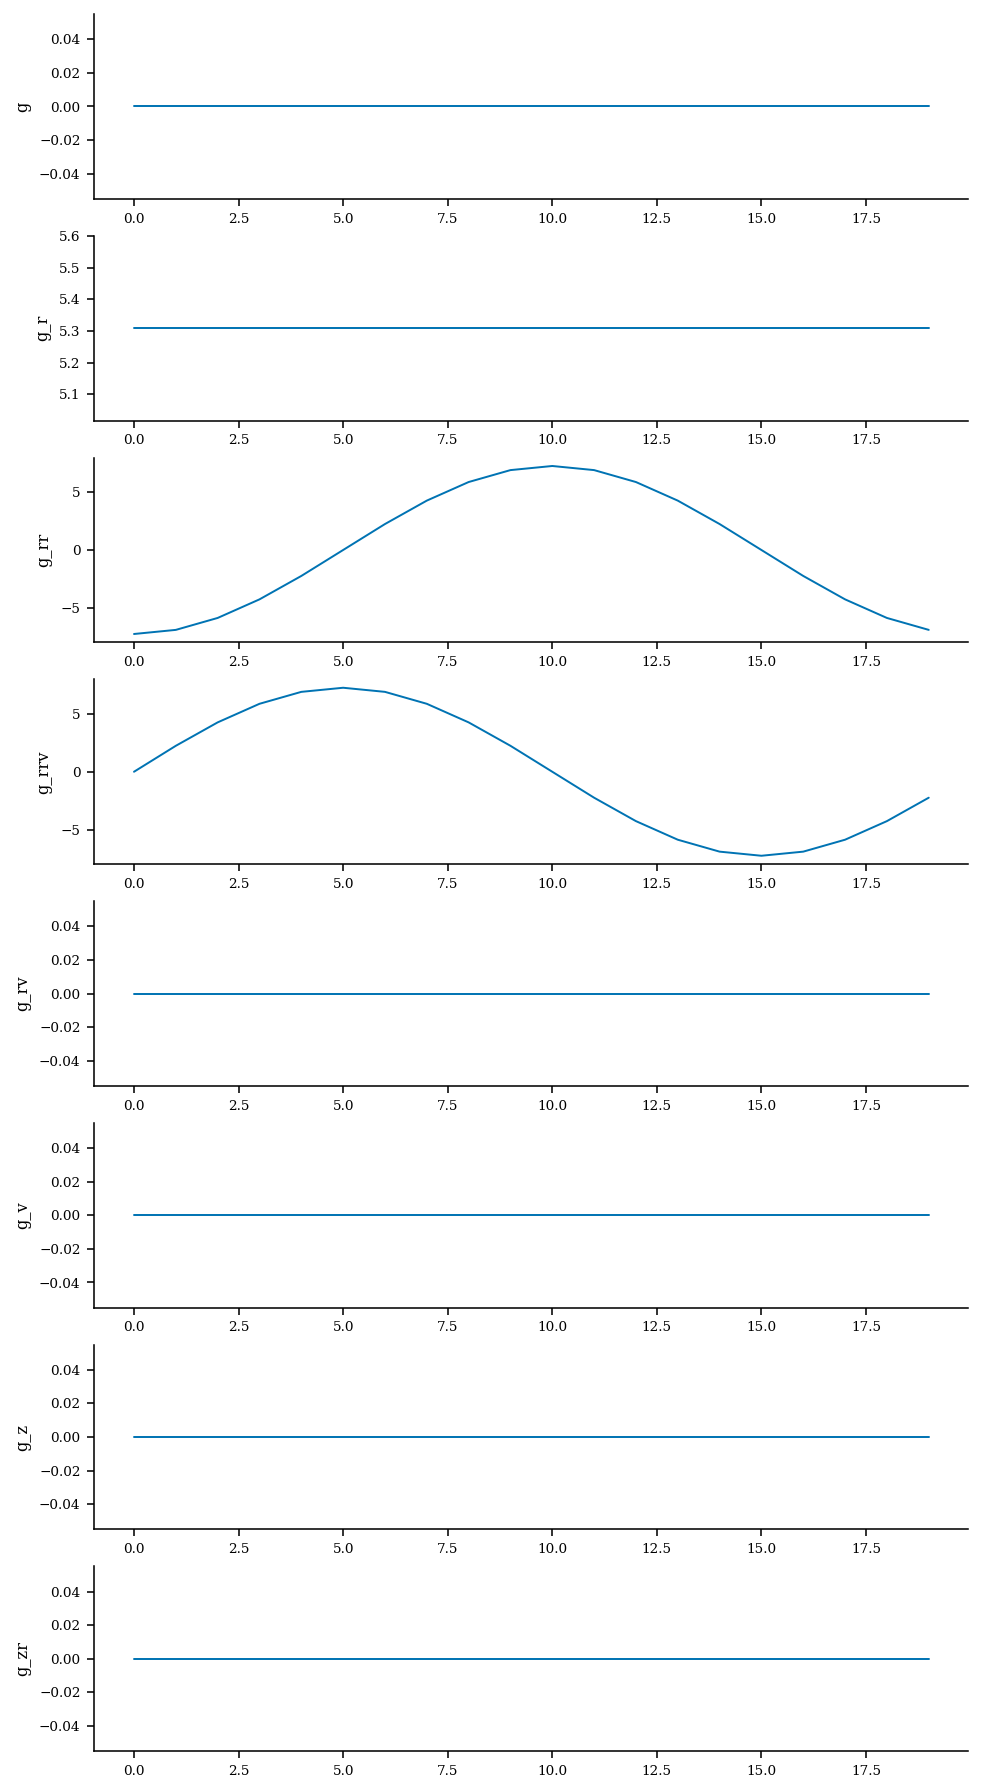

In [27]:
data = jacobian
fig, ax = plt.subplots(len(data),figsize=(8,16))

for i,(key,val) in enumerate(data.items()):
    if val.ndim >1:
        val = val.T
    ax[i].plot(val[axn],lw=1)
    ax[i].set_ylabel(key)
    if np.any(np.isnan(val)):
        print(key)

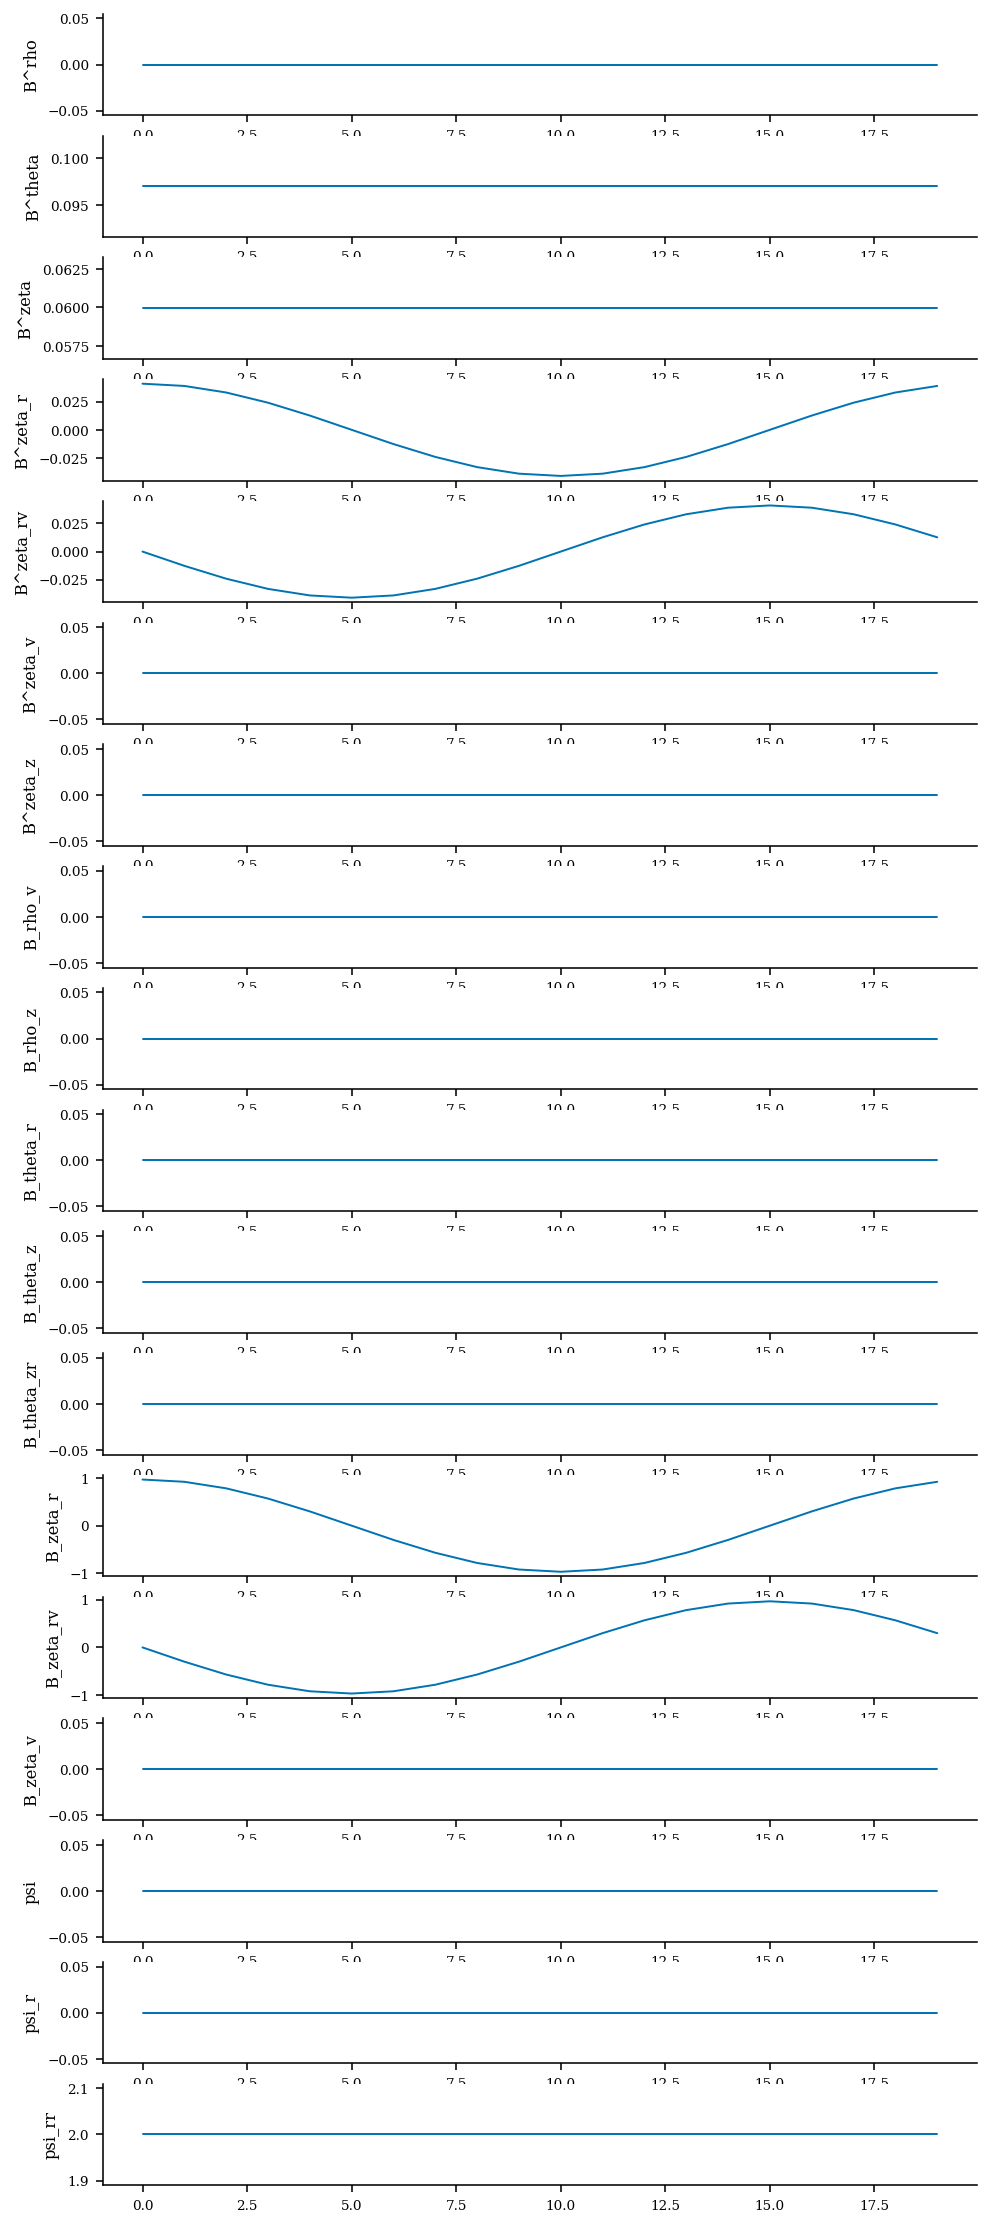

In [21]:
data = B_field
fig, ax = plt.subplots(len(data),figsize=(8,20))

for i,(key,val) in enumerate(data.items()):
    if val.ndim >1:
        val = val.T
    ax[i].plot(val[axn],lw=1)
    ax[i].set_ylabel(key)
    if np.any(np.isnan(val)):
        print(key)

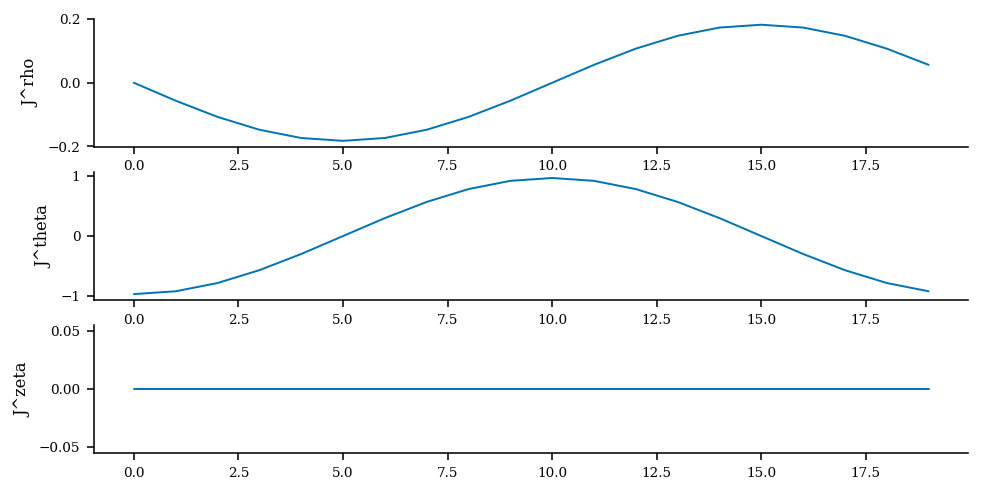

In [28]:
data = J_field
fig, ax = plt.subplots(len(data),figsize=(8,4))

for i,(key,val) in enumerate(data.items()):
    if val.ndim >1:
        val = val.T
    ax[i].plot(val[axn],lw=1)
    ax[i].set_ylabel(key)
    if np.any(np.isnan(val)):
        print(key)

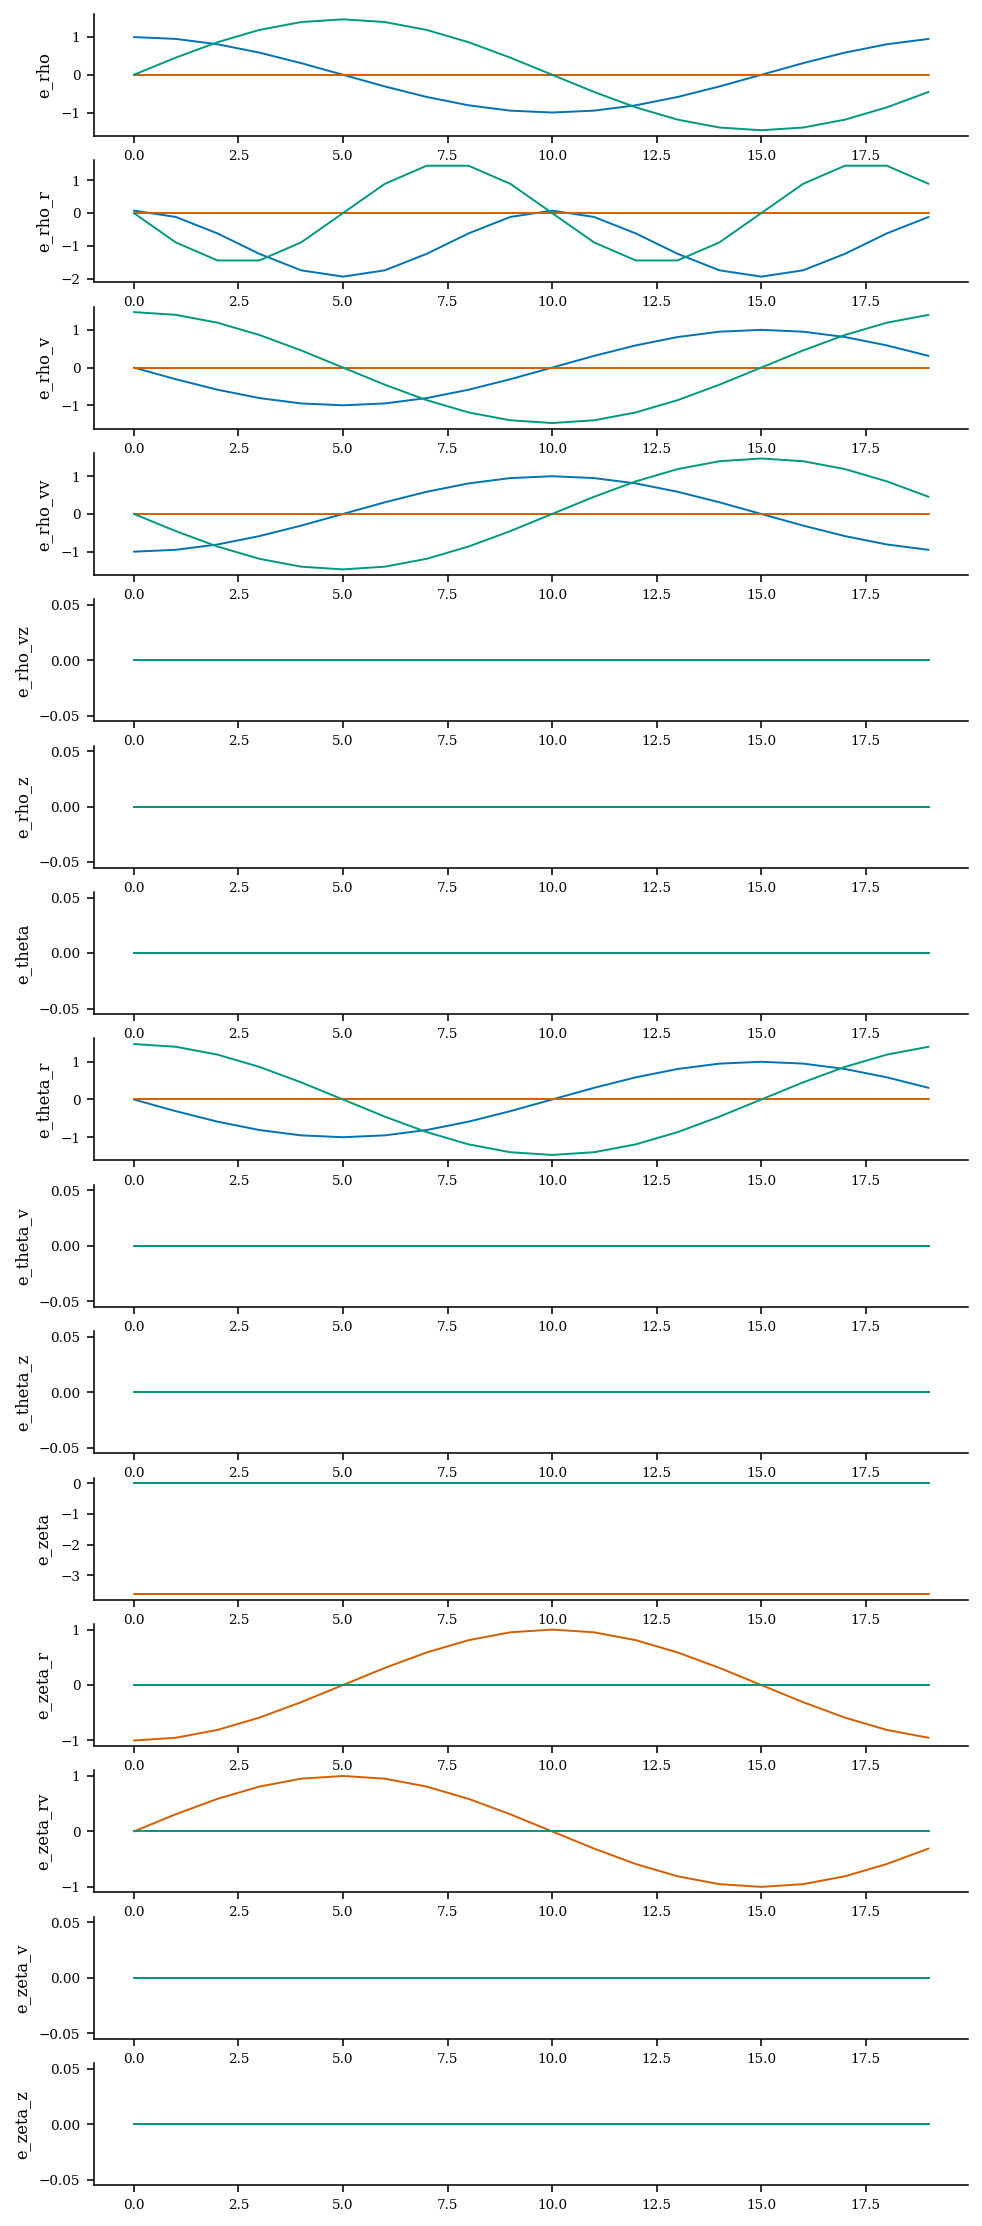

In [23]:
data = cov_basis
fig, ax = plt.subplots(len(data),figsize=(8,20))

for i,(key,val) in enumerate(data.items()):
    if val.ndim >1:
        val = val.T
    ax[i].plot(val[axn],lw=1)
    ax[i].set_ylabel(key)
    if np.any(np.isnan(val)):
        print(key)

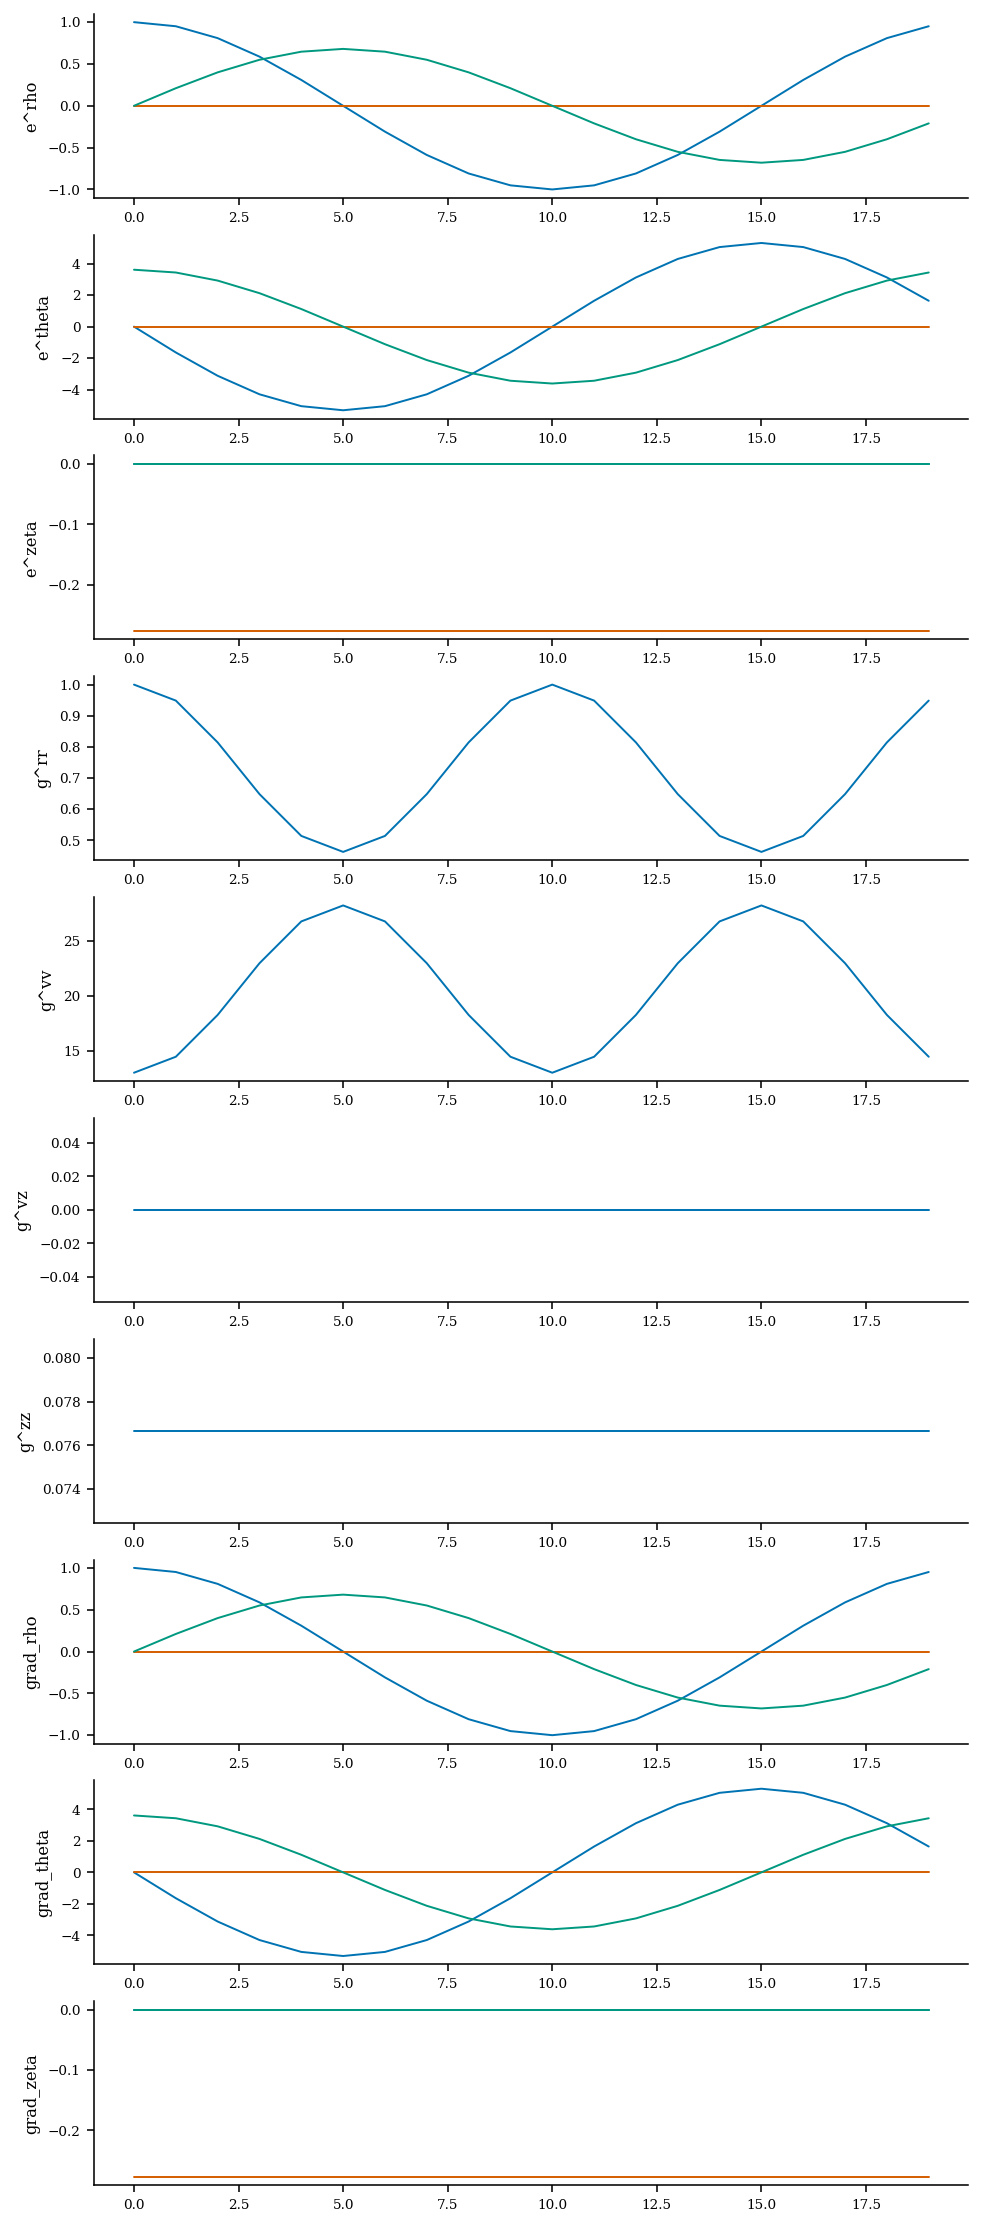

In [24]:
data = con_basis
fig, ax = plt.subplots(len(data),figsize=(8,20))

for i,(key,val) in enumerate(data.items()):
    if val.ndim >1:
        val = val.T
    ax[i].plot(val[axn],lw=1)
    ax[i].set_ylabel(key)
    if np.any(np.isnan(val)):
        print(key)

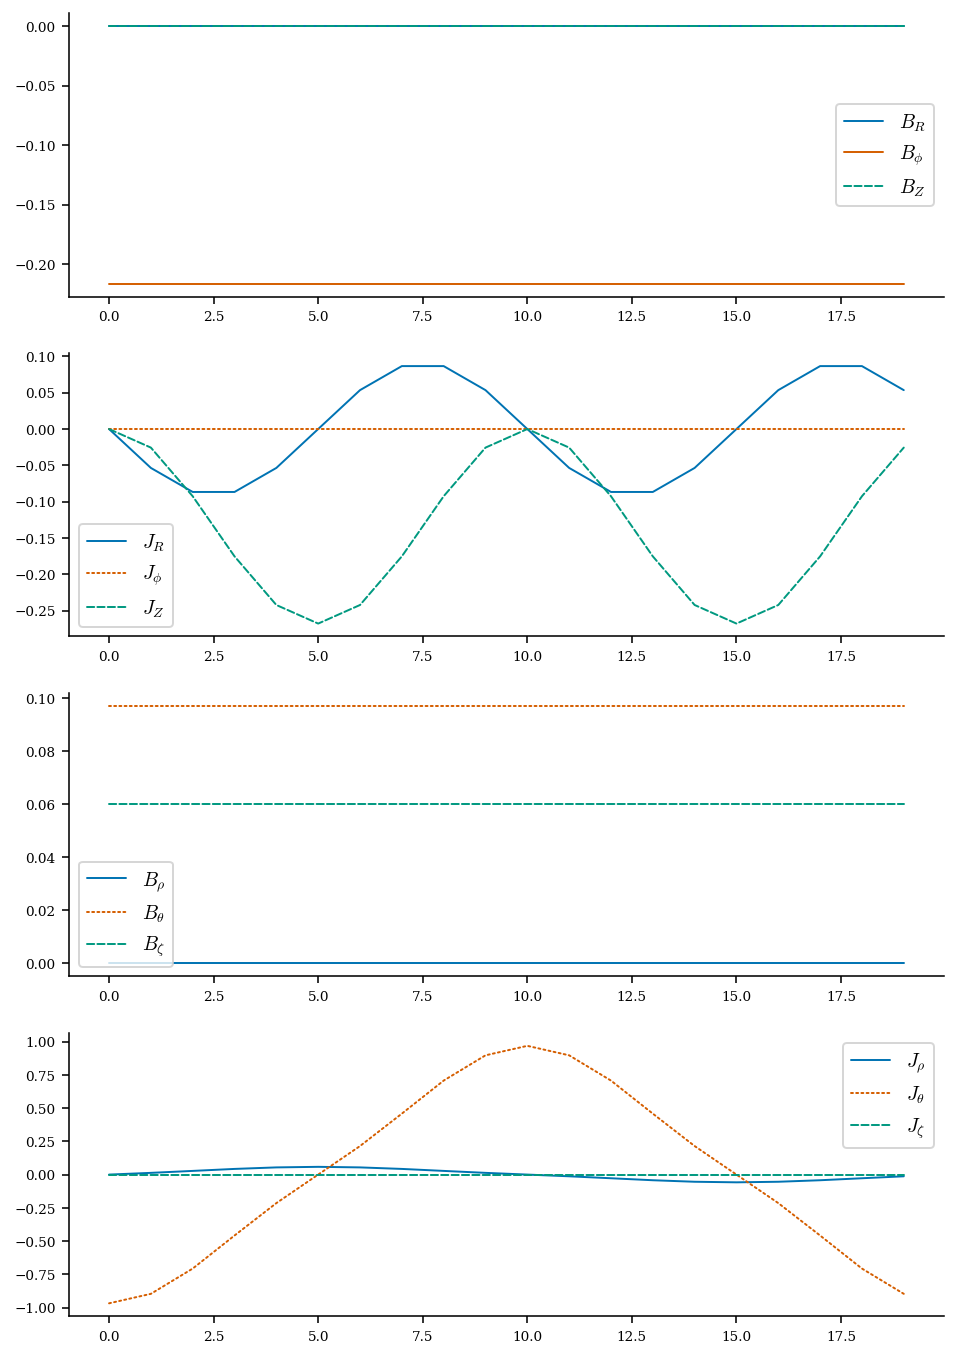

In [26]:
B = B_field['B^zeta']*cov_basis['e_zeta'] + B_field['B^theta']*cov_basis['e_theta'] \
    + B_field['B^rho']*cov_basis['e_rho']
# J = J_field['J^zeta']*cov_basis['e_zeta'] + J_field['J^theta']*cov_basis['e_theta'] \
#     + J_field['J^rho']*cov_basis['e_rho']
J = J_field['J^zeta']*cov_basis['e_zeta'] \
    + J_field['J^rho']*cov_basis['e_rho']

fig, ax = plt.subplots(4, figsize=(8,12))

ax[0].plot(B[0][axn],lw=1,label='$B_R$')
ax[0].plot(B[1][axn],lw=1,label='$B_\\phi$')
ax[0].plot(B[2][axn],lw=1,ls='--',label='$B_Z$')
ax[0].legend()
ax[1].plot(J[0][axn],lw=1,label='$J_R$')
ax[1].plot(J[1][axn],lw=1,ls=':',label='$J_\\phi$')
ax[1].plot(J[2][axn],lw=1,ls='--',label='$J_Z$')
ax[1].legend()
ax[2].plot(B_field['B^rho'][axn],lw=1,label='$B_\\rho$')
ax[2].plot(B_field['B^theta'][axn],lw=1,ls=':',label='$B_\\theta$')
ax[2].plot(B_field['B^zeta'][axn],lw=1,ls='--',label='$B_\zeta$')
ax[2].legend()
ax[3].plot(J_field['J^rho'][axn]*helical[axn],lw=1,label='$J_\\rho$')
ax[3].plot(J_field['J^theta'][axn]*radial[axn],lw=1,ls=':',label='$J_\\theta$')
ax[3].plot(J_field['J^zeta'][axn]*radial[axn],lw=1,ls='--',label='$J_\zeta$')
ax[3].legend()

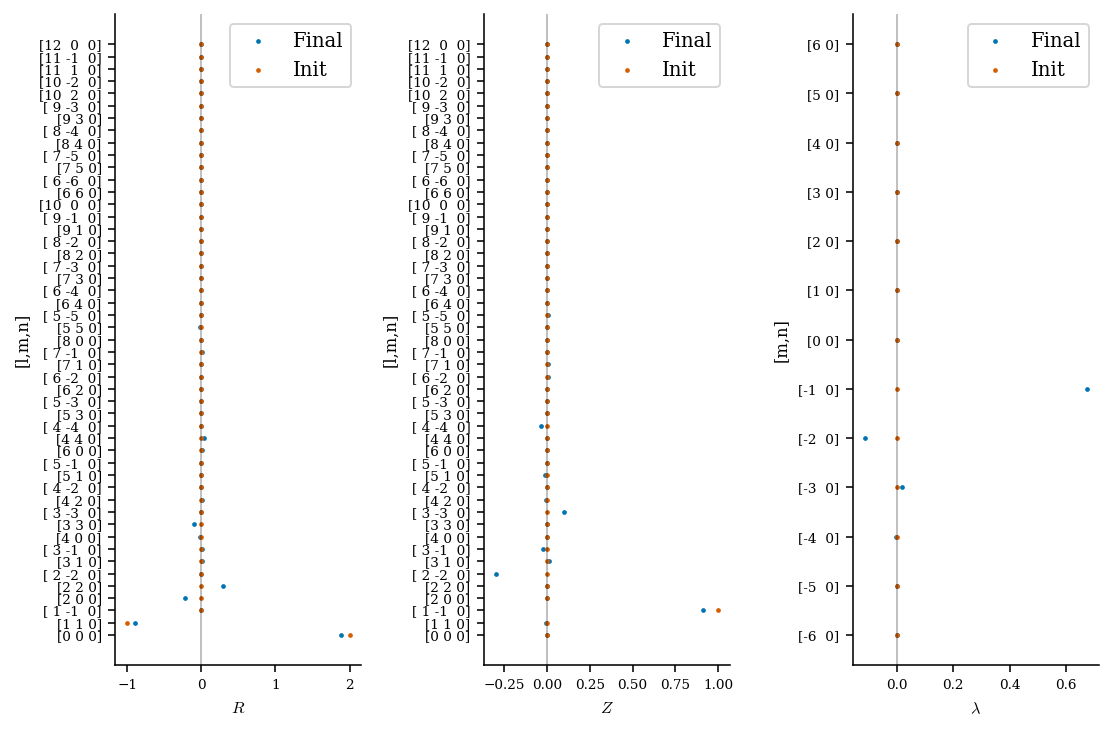

In [223]:
plot_coeffs(cR,cZ,cL,zern_idx,lambda_idx,cR_init,cZ_init,cL_init);

In [58]:
force_obj = jit(force_obj, static_argnums=np.arange(1,15))
force_jac = jit(jax.jacfwd(force_obj),static_argnums=np.arange(1,15))
bc_constraint_fun = jit(bc_constraint_fun, static_argnums=np.arange(1,15))
bc_jac = jit(jax.jacfwd(bc_constraint_fun),static_argnums=np.arange(1,15))

force_obj(x_init,*args).block_until_ready();
force_jac(x_init,*args).block_until_ready();
bc_constraint_fun(x_init,*args).block_until_ready();
bc_jac(x_init,*args).block_until_ready();

In [59]:
slsqp_constraints=[{'type':'eq',
                    'fun':lambda_constraint_fun,
                    'jac':lambda_jac if use_jax else None,
                    'args': args},
                   {'type':'eq',
                    'fun':bc_constraint_fun,
                    'jac':bc_jac if use_jax else None,
                    'args': args}]

trf_constraints = [scipy.optimize.NonlinearConstraint(lambda x: bc_constraint_fun(x,*args), 
                                                      -1e-3, 
                                                      1e-3, 
                                                      jac=lambda x: bc_jac(x,*args), 
                                                      keep_feasible=False, 
                                                      ),
                   scipy.optimize.LinearConstraint(get_lambda_constraint_matrix(M,N,NFP), 0, 0)
                  ]

# out = scipy.optimize.minimize(force_obj,
#                               x_init,
#                               args=args,
#                               method='SLSQP',
#                               jac=force_jac if use_jax else None,
#                               options={'disp':True,
#                                        'maxiter':500},
#                               constraints=slsqp_constraints,
#                               callback=callback
#                              )

out = scipy.optimize.minimize(force_obj,
                              x_init,
                              args=args,
                              method='trust-constr',
                              jac=force_jac if use_jax else None,
                              options={'disp':True,
                                       'maxiter':5000},
                              constraints=trf_constraints,
#                               callback=callback
                             )

Loss:  2.228e+04  errF:  2.731e-02  errR:  4.026e-07  errZ:  6.097e-16  errL:  0.000e+00
The maximum number of function evaluations is exceeded.
Number of iterations: 5001, function evaluations: 5001, CG iterations: 5197, optimality: 2.50e-01, constraint violation: 1.05e-07, execution time: 7.9e+01 s.


In [60]:
callback(x_init)
callback(out['x'])

Loss:  2.228e+04  errF:  2.731e-02  errR:  4.026e-07  errZ:  6.097e-16  errL:  0.000e+00
Loss:  1.259e+04  errF:  1.544e-02  errR:  2.934e-06  errZ:  2.339e-06  errL:  1.052e-07


In [ ]:
fig = plt.figure(figsize=(9,6))

mmax = 5
npts = 100
nlm = (mmax+1)**2
lm = np.array([fringe_to_lm(i) for i in range(nlm)])
levels = np.linspace(-1,1,npts)
lmax = np.max(lm[:,0])
ax = {i:{} for i in range(lmax+1)}
gs = matplotlib.gridspec.GridSpec(lmax+1, 2*(mmax+1)) 
for l,m in lm:
    r = np.linspace(0,1,npts)
    v = np.linspace(0,2*jnp.pi,npts)
    rr,vv = np.meshgrid(r,v,indexing='ij')
    Z = zern(rr.flatten(),vv.flatten(),l,m,0,0).reshape((npts,npts))
    
    ax[l][m] = plt.subplot(gs[l,m+mmax:m+mmax+2],projection='polar')
    ax[l][m].set_title('n=' + str(lm_to_fringe(l,m)) + '\n$\mathcal{Z}_{' + str(l) + '}^{' + str(m) + '}$')
    ax[l][m].axis('off')
    im = ax[l][m].contourf(v,r,Z,levels=levels,cmap='coolwarm')

cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
plt.subplots_adjust(right=.8)
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_ticks(np.linspace(-1, 1, 9))

In [ ]:
fig, ax = plt.subplots()

mmax = 5
npts = 1000
nlm = (mmax+1)**2
lm = np.array([fringe_to_lm(i) for i in range(nlm)])
r = np.linspace(0,1,npts)

for l,m in lm:
    if (l-m)%2 == 0 and m>=0:
        ax.plot(r,zern_radial(r,l,m),lw=1,label='$l={},m={}$'.format(l,m))
plt.subplots_adjust(bottom=.45)
fig.legend(ncol=4, loc='lower center',)

# Gfile stuff

In [91]:
def DESC_to_gfile(cR,cZ,iotafun_params,presfun_params,Psi_total,zern_idx,NFP,nw=65,nh=65,nr=50,ntheta=50,npsi=1000, 
                  rdim=None,zdim=None,rleft=None,rcentr=None,zmid=None,axis_flux=0):

    g = {}
    g['date']=pytime.localtime()
    g['shot']=0
    g['time']=0
    g['efit']='DESC'
    g['nw']=nw
    g['nh']=nh


    # get poloidal flux (psi) as function of toroidal flux (rho)
    efitPsi = np.linspace(0,1,g['nw'])
    rho_n = np.linspace(5e-2,1,npsi)
    rho = 2*Psi_total*rho_n
    iota = iotafun(rho_n,0,iotafun_params)
    psi = scipy.integrate.cumtrapz(rho*iota,rho_n,initial=axis_flux)
    psi_n = (psi - np.min(psi))/(np.max(psi)-np.min(psi))
    psi_n_of_rho_n = scipy.interpolate.CubicSpline(rho_n,psi_n)
    psi_of_rho_n = scipy.interpolate.CubicSpline(rho_n,psi)
    rho_n_of_psi_n = scipy.interpolate.CubicSpline(psi_n,rho_n)

    # get Bt
    vv = np.zeros_like(rho_n)
    zz = np.zeros_like(rho_n)
    nodes = np.stack([rho_n,vv,zz])
    axn = np.where(nodes[0]==0)[0]
    derivatives = get_needed_derivatives('force')
    zernt = ZernikeTransform(nodes,zern_idx,NFP,derivatives)
    coord_der = compute_coordinate_derivatives(cR,cZ,zernt)
    cov_basis = compute_covariant_basis(coord_der)
    jacobian = compute_jacobian(coord_der,cov_basis)
    B_field = compute_B_field(Psi_total, jacobian, nodes, axn, cov_basis, iotafun_params)
    R = zernt.transform(cR,0,0,0).flatten()
    B = B_field['B^theta']*cov_basis['e_theta'] + B_field['B^zeta']*cov_basis['e_zeta']
    Bt = B[1]
    g['bcentr'] = np.linalg.norm(B[:,0])

    # compute profiles
    Fpol = scipy.interpolate.CubicSpline(psi_n,R*Bt)
    FF = scipy.interpolate.CubicSpline(psi_n,(R*Bt)**2)
    g['fpol'] = Fpol(efitPsi)
    g['ffprime'] = 1/2*FF(efitPsi,nu=1)
    g['pres'] = presfun(rho_n_of_psi_n(efitPsi),0,presfun_params)
    g['pprime'] = presfun(rho_n_of_psi_n(efitPsi),1,presfun_params)*rho_n_of_psi_n(efitPsi,nu=1)
    iotapsi = iotafun(rho_n_of_psi_n(efitPsi),0,iotafun_params)
    qidx = np.where(iotapsi != 0)[0]
    g['qpsi'] = scipy.interpolate.CubicSpline(efitPsi[qidx],1/iotapsi[qidx])(efitPsi)


    # compute psi(R,Z) and total current
    r = np.linspace(0,1,nr)
    v = np.linspace(0,2*np.pi,ntheta)
    rr,vv = np.meshgrid(r,v,indexing='ij')
    rr = rr.flatten()
    vv = vv.flatten()
    zz = np.zeros_like(rr)
    nodes = np.stack([rr,vv,zz])
    volumes = np.stack([np.ones_like(rr)*1/nr,np.ones_like(vv)*2*np.pi/ntheta,np.ones_like(zz)])
    axn = np.where(rr==0)[0]
    r1 = np.min(r[r != 0])
    r1idx = np.where(r == r1)[0]
    bdryn = np.where(rr==1)[0]
    zernt = ZernikeTransform(nodes,zern_idx,NFP,derivatives)

    
    coord_der = compute_coordinate_derivatives(cR,cZ,zernt)
    cov_basis = compute_covariant_basis(coord_der)
    jacobian = compute_jacobian(coord_der,cov_basis)
    B_field = compute_B_field(Psi_total, jacobian, nodes, axn, cov_basis, iotafun_params)
    J_field = compute_J_field(B_field, jacobian, nodes, axn)
    con_basis = compute_contravariant_basis(coord_der, cov_basis, jacobian, nodes, axn)
    mu0 = 4*np.pi*1e-7
    J = J_field['J^zeta']*cov_basis['e_zeta'] + J_field['J^theta']*cov_basis['e_theta'] \
        + J_field['J^rho']*cov_basis['e_rho']
    vol = volumes[0]*volumes[1]*volumes[2]*jacobian['g']
    vol = put(vol, axn, jnp.mean(jacobian['g'][r1idx])/2*volumes[0,axn]*volumes[1,axn]*volumes[2,axn])

    I = np.sum((J*vol)[1])/mu0
    g['current'] = I
    
    R = zernt.transform(cR,0,0,0).flatten()
    Z = zernt.transform(cZ,0,0,0).flatten()
    psiRZ = psi_of_rho_n(rr)

    g['rmaxis'] = np.mean(R[axn])
    g['zmaxis'] = np.mean(Z[axn])
    g['nbbbs'] = bdryn.size
    g['rbbbs'] = R[bdryn]
    g['zbbbs'] = Z[bdryn]
    g['axis_flux'] = np.mean(psiRZ[axn])
    g['boundary_flux'] = np.mean(psiRZ[bdryn])

    g['rdim'] = rdim if rdim else (np.max(R)-np.min(R))*1.5
    g['rcentr'] = rcentr if rcentr else (np.max(R)+np.min(R))/2
    g['zdim'] = zdim if zdim else (np.max(Z)-np.min(Z))*1.5
    g['zmid'] = zmid if zmid else (np.max(Z)+np.min(Z))/2
    g['rleft'] = rleft if rleft else g['rcentr'] - g['rdim']/2

    efitR = np.linspace(g['rleft'],g['rleft']+g['rdim'],g['nw'])
    efitZ = np.linspace(-g['zdim']/2,g['zdim']/2,g['nh'])
    efitRR,efitZZ = np.meshgrid(efitR,efitZ,indexing='ij')

    g['psirz'] = scipy.interpolate.griddata((R,Z),psiRZ,(efitRR,efitZZ),method='cubic').T
    g['psirz'][np.isnan(g['psirz'])] = g['boundary_flux']

    g['limitr'] = 0
    g['rlimitr'] = np.array([])
    g['zlimitr'] = np.array([])
    
    return g

(<Figure size 1128x846 with 7 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ef044041cf8>,
       dtype=object))

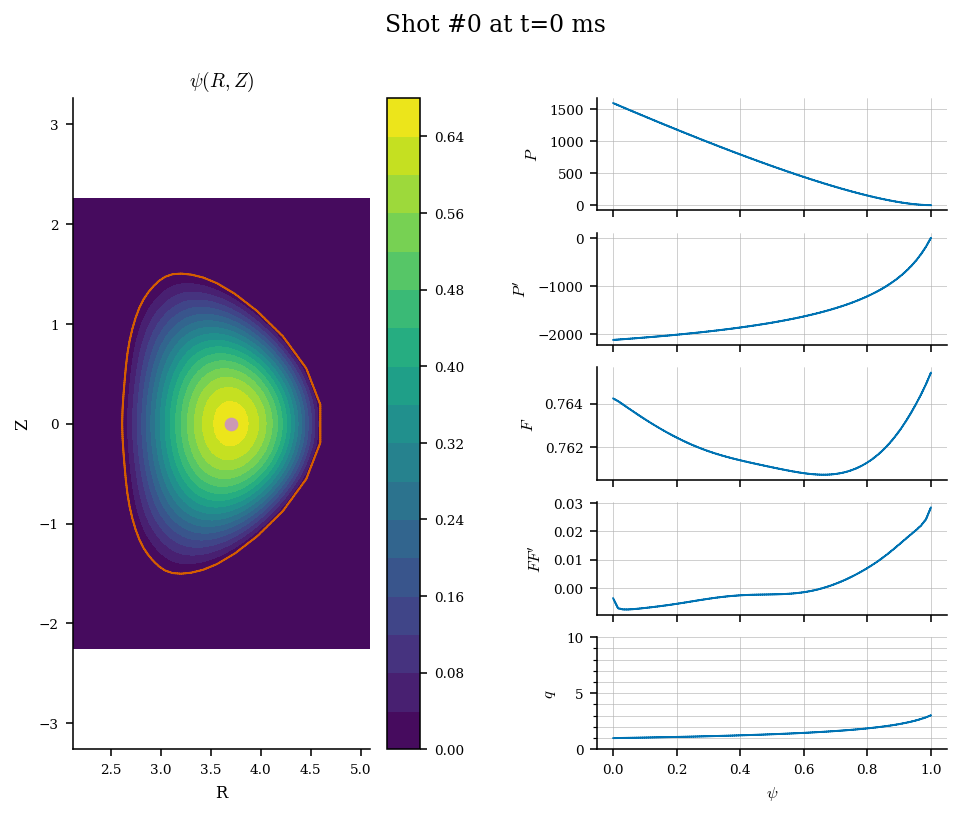

In [92]:
g = DESC_to_gfile(cR,cZ,iotafun_params,presfun_params,Psi_total,zern_idx,NFP)
plot_gfile(g)

In [93]:
g['current']

DeviceArray(-2027211.84900029, dtype=float64)

In [94]:
write_gfile('g.dshape',**g)

In [101]:
np.stack([np.arange(0),np.linspace(0,1,0)]).T.flatten()

array([], dtype=float64)

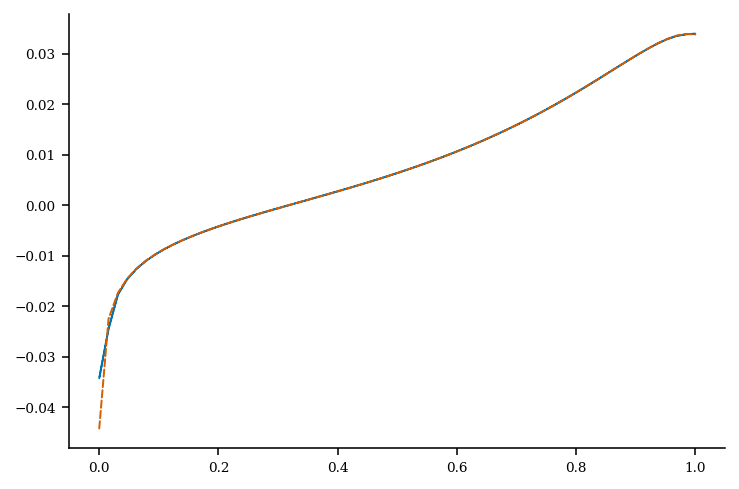

In [35]:
plt.plot(np.linspace(0,1,65),g['fpol']*np.gradient(g['fpol'],np.linspace(0,1,65),edge_order=2))
plt.plot(np.linspace(0,1,65),g['ffprime'])

In [61]:
import sympy
from sympy import symbols, Function, Matrix, diff, pi, latex, expand, simplify, zeros, eye, det, sqrt, fraction
from IPython.display import display, Math, Latex

rho, theta, zeta = symbols(['\\rho','\\theta','\zeta'], real=True)
BR = Function('B_\\rho', real=True)(rho,theta,zeta)
BT = Function('B_\\theta', real=True)(rho,theta,zeta)
BZ = Function('B_\\zeta', real=True)(rho,theta,zeta)



R = Function('R', real=True)(rho,theta,zeta)
Z = Function('Z', real=True)(rho,theta,zeta)

e_r = Matrix([R.diff(rho),   0, Z.diff(rho)])
e_t = Matrix([R.diff(theta), 0, Z.diff(theta)])
e_z = Matrix([R.diff(zeta),  -R, Z.diff(zeta)])

g = e_t.cross(e_z).dot(e_r)

JR = (BZ.diff(theta) - BT.diff(zeta))/g
JT = (BR.diff(zeta) - BZ.diff(rho))/g
JZ = (BT.diff(rho) - BR.diff(theta))/g

J = JR*e_r + JT*e_t + JZ*e_z
# J = simplify(J)


In [65]:
print('J_R num')
display(fraction(simplify(J)[0])[0].diff(rho))
print('J_R den')
display(fraction(simplify(J)[0])[1].diff(rho))

print('J_phi num')
display(fraction(simplify(J)[1])[0].diff(rho))
print('J_phi den')
display(fraction(simplify(J)[1])[1].diff(rho))

print('J_Z num')
display(fraction(simplify(J)[2])[0].diff(rho))
print('J_Z den')
display(fraction(simplify(J)[2])[1].diff(rho))

J_R num


(-Derivative(B_\rho(\rho, \theta, \zeta), \theta) + Derivative(B_\theta(\rho, \theta, \zeta), \rho))*Derivative(R(\rho, \theta, \zeta), \rho, \zeta) + (Derivative(B_\rho(\rho, \theta, \zeta), \zeta) - Derivative(B_\zeta(\rho, \theta, \zeta), \rho))*Derivative(R(\rho, \theta, \zeta), \rho, \theta) + (Derivative(B_\theta(\rho, \theta, \zeta), (\rho, 2)) - Derivative(B_\rho(\rho, \theta, \zeta), \rho, \theta))*Derivative(R(\rho, \theta, \zeta), \zeta) + (-Derivative(B_\theta(\rho, \theta, \zeta), \zeta) + Derivative(B_\zeta(\rho, \theta, \zeta), \theta))*Derivative(R(\rho, \theta, \zeta), (\rho, 2)) + (-Derivative(B_\zeta(\rho, \theta, \zeta), (\rho, 2)) + Derivative(B_\rho(\rho, \theta, \zeta), \rho, \zeta))*Derivative(R(\rho, \theta, \zeta), \theta) + (-Derivative(B_\theta(\rho, \theta, \zeta), \rho, \zeta) + Derivative(B_\zeta(\rho, \theta, \zeta), \rho, \theta))*Derivative(R(\rho, \theta, \zeta), \rho)

J_R den


(Derivative(R(\rho, \theta, \zeta), \rho)*Derivative(Z(\rho, \theta, \zeta), \theta) - Derivative(R(\rho, \theta, \zeta), \theta)*Derivative(Z(\rho, \theta, \zeta), \rho))*Derivative(R(\rho, \theta, \zeta), \rho) + (Derivative(R(\rho, \theta, \zeta), \rho)*Derivative(Z(\rho, \theta, \zeta), \rho, \theta) + Derivative(R(\rho, \theta, \zeta), (\rho, 2))*Derivative(Z(\rho, \theta, \zeta), \theta) - Derivative(R(\rho, \theta, \zeta), \theta)*Derivative(Z(\rho, \theta, \zeta), (\rho, 2)) - Derivative(Z(\rho, \theta, \zeta), \rho)*Derivative(R(\rho, \theta, \zeta), \rho, \theta))*R(\rho, \theta, \zeta)

J_phi num


-Derivative(B_\theta(\rho, \theta, \zeta), (\rho, 2)) + Derivative(B_\rho(\rho, \theta, \zeta), \rho, \theta)

J_phi den


Derivative(R(\rho, \theta, \zeta), \rho)*Derivative(Z(\rho, \theta, \zeta), \rho, \theta) + Derivative(R(\rho, \theta, \zeta), (\rho, 2))*Derivative(Z(\rho, \theta, \zeta), \theta) - Derivative(R(\rho, \theta, \zeta), \theta)*Derivative(Z(\rho, \theta, \zeta), (\rho, 2)) - Derivative(Z(\rho, \theta, \zeta), \rho)*Derivative(R(\rho, \theta, \zeta), \rho, \theta)

J_Z num


(-Derivative(B_\rho(\rho, \theta, \zeta), \theta) + Derivative(B_\theta(\rho, \theta, \zeta), \rho))*Derivative(Z(\rho, \theta, \zeta), \rho, \zeta) + (Derivative(B_\rho(\rho, \theta, \zeta), \zeta) - Derivative(B_\zeta(\rho, \theta, \zeta), \rho))*Derivative(Z(\rho, \theta, \zeta), \rho, \theta) + (Derivative(B_\theta(\rho, \theta, \zeta), (\rho, 2)) - Derivative(B_\rho(\rho, \theta, \zeta), \rho, \theta))*Derivative(Z(\rho, \theta, \zeta), \zeta) + (-Derivative(B_\theta(\rho, \theta, \zeta), \zeta) + Derivative(B_\zeta(\rho, \theta, \zeta), \theta))*Derivative(Z(\rho, \theta, \zeta), (\rho, 2)) + (-Derivative(B_\zeta(\rho, \theta, \zeta), (\rho, 2)) + Derivative(B_\rho(\rho, \theta, \zeta), \rho, \zeta))*Derivative(Z(\rho, \theta, \zeta), \theta) + (-Derivative(B_\theta(\rho, \theta, \zeta), \rho, \zeta) + Derivative(B_\zeta(\rho, \theta, \zeta), \rho, \theta))*Derivative(Z(\rho, \theta, \zeta), \rho)

J_Z den


(Derivative(R(\rho, \theta, \zeta), \rho)*Derivative(Z(\rho, \theta, \zeta), \theta) - Derivative(R(\rho, \theta, \zeta), \theta)*Derivative(Z(\rho, \theta, \zeta), \rho))*Derivative(R(\rho, \theta, \zeta), \rho) + (Derivative(R(\rho, \theta, \zeta), \rho)*Derivative(Z(\rho, \theta, \zeta), \rho, \theta) + Derivative(R(\rho, \theta, \zeta), (\rho, 2))*Derivative(Z(\rho, \theta, \zeta), \theta) - Derivative(R(\rho, \theta, \zeta), \theta)*Derivative(Z(\rho, \theta, \zeta), (\rho, 2)) - Derivative(Z(\rho, \theta, \zeta), \rho)*Derivative(R(\rho, \theta, \zeta), \rho, \theta))*R(\rho, \theta, \zeta)

In [33]:
B_field.keys()

dict_keys(['B^rho', 'B^theta', 'B^zeta', 'B^zeta_r', 'B^zeta_rv', 'B^zeta_v', 'B^zeta_z', 'B_rho_v', 'B_rho_z', 'B_theta_r', 'B_theta_z', 'B_theta_zr', 'B_zeta_r', 'B_zeta_rv', 'B_zeta_v', 'psi', 'psi_r', 'psi_rr'])

In [34]:
coord_der.keys()

dict_keys(['0', 'R', 'R_r', 'R_rr', 'R_rrv', 'R_rrvv', 'R_rv', 'R_rvv', 'R_rz', 'R_v', 'R_vr', 'R_vv', 'R_vz', 'R_z', 'R_zr', 'R_zrv', 'R_zv', 'R_zz', 'Z', 'Z_r', 'Z_rr', 'Z_rrv', 'Z_rrvv', 'Z_rv', 'Z_rvv', 'Z_rz', 'Z_v', 'Z_vr', 'Z_vv', 'Z_vz', 'Z_z', 'Z_zr', 'Z_zrv', 'Z_zv', 'Z_zz'])

In [53]:
num = (-B_field['B_rho_v'] + B_field['B_theta_r'])*coord_der['R_z'] + (B_field['B_rho_z'] - B_field['B_zeta_r'])*coord_der['R_v'] \
    - (B_field['B_theta_z'] - B_field['B_zeta_v'])*coord_der['R_r']

dnum = (-B_field['B_rho_v'] + B_field['B_theta_r'])*coord_der['R_rz'] + (B_field['B_rho_z'] - B_field['B_zeta_r'])*coord_der['R_rv'] \
    - (B_field['B_theta_z'] - B_field['B_zeta_v'])*coord_der['R_rr'] + (-B_field['B_rho_rv'] + B_field['B_theta_rr'])*coord_der['R_z'] \
    + (B_field['B_rho_rz'] - B_field['B_zeta_rr'])*coord_der['R_v'] - (B_field['B_theta_rz'] - B_field['B_zeta_rv'])*coord_der['R_r']

den = (coord_der['R_r']*coord_der['Z_v'] - coord_der['R_v']*coord_der['Z_r'])*coord_der['R']

dden = (coord_der['R_rr']*coord_der['Z_v'] + coord_der['R_r']*coord_der['Z_rv']
        - coord_der['R_rv']*coord_der['Z_r'] - coord_der['R_v']*coord_der['Z_rr'])*coord_der['R'] + (coord_der['R_r']*coord_der['Z_v'] - coord_der['R_v']*coord_der['Z_r'])*coord_der['R_r']

KeyError: 'B_rho_rv'

In [66]:
from sympy import symbols, Function, Matrix, diff, pi, latex, expand, simplify, zeros, eye, det, sqrt

rho, theta, zeta = symbols(['\\rho','\\theta','\zeta'], real=True)
X = Matrix([rho,theta,zeta])
R = Function('R', real=True)(rho,theta,zeta)
Z = Function('Z', real=True)(rho,theta,zeta)

e_r = Matrix([R.diff(rho),   0, Z.diff(rho)])
e_t = Matrix([R.diff(theta), 0, Z.diff(theta)])
e_z = Matrix([R.diff(zeta),  -R, Z.diff(zeta)])
psi = Function('\\Psi')(rho)
iota = Function('\iota')(rho)
covG = eye(3)
conG = eye(3)
covE = Matrix([e_r.T,e_t.T,e_z.T]).T
covE = simplify(covE)

g = e_t.cross(e_z).dot(e_r)
eR = e_t.cross(e_z)/g
eT = e_z.cross(e_r)/g
eZ = e_r.cross(e_t)/g

conE = Matrix([eR.T,eT.T,eZ.T]).T
conE = simplify(conE)

for i in range(3):
    for j in range(3):
        covG[i,j] = covE[:,i].dot(covE[:,j])
        conG[i,j] = conE[:,i].dot(conE[:,j])

BZ = psi.diff(rho)/(2*pi*g)
BT = iota*BZ

conB = Matrix([0,BT,BZ])
conB = simplify(conB)

covB = covG*conB
covB = simplify(covB)

conJ = zeros(3,1)

for i in range(3):
    for j in range(3):
        conJ += covB[j].diff(X[i])*conE[:,i].cross(conE[:,j])

# conJ = simplify(conJ)

B = BZ*e_z + BT*e_t
J = covE*conJ

JxB = J.cross(B)


In [70]:
simplify(covB[0].diff(rho,rho))

(((Derivative(R(\rho, \theta, \zeta), \rho)*Derivative(Z(\rho, \theta, \zeta), \theta) - Derivative(R(\rho, \theta, \zeta), \theta)*Derivative(Z(\rho, \theta, \zeta), \rho))*(-Derivative(R(\rho, \theta, \zeta), \rho)*Derivative(Z(\rho, \theta, \zeta), (\rho, 2), \theta) - 2*Derivative(R(\rho, \theta, \zeta), (\rho, 2))*Derivative(Z(\rho, \theta, \zeta), \rho, \theta) - Derivative(R(\rho, \theta, \zeta), (\rho, 3))*Derivative(Z(\rho, \theta, \zeta), \theta) + Derivative(R(\rho, \theta, \zeta), \theta)*Derivative(Z(\rho, \theta, \zeta), (\rho, 3)) + Derivative(Z(\rho, \theta, \zeta), \rho)*Derivative(R(\rho, \theta, \zeta), (\rho, 2), \theta) + 2*Derivative(Z(\rho, \theta, \zeta), (\rho, 2))*Derivative(R(\rho, \theta, \zeta), \rho, \theta)) + 2*(Derivative(R(\rho, \theta, \zeta), \rho)*Derivative(Z(\rho, \theta, \zeta), \rho, \theta) + Derivative(R(\rho, \theta, \zeta), (\rho, 2))*Derivative(Z(\rho, \theta, \zeta), \theta) - Derivative(R(\rho, \theta, \zeta), \theta)*Derivative(Z(\rho, \

In [103]:
from sympy import symbols, Function, Matrix, diff, pi, latex, expand, simplify, zeros, eye, det, sqrt
from sympy.vector import CoordSys3D, curl, gradient, divergence

rho, theta, zeta = symbols(['\\rho','\\theta','\zeta'], real=True)
X = Matrix([rho,theta,zeta])
R = Function('R', real=True)(rho,theta,zeta)
Z = Function('Z', real=True)(rho,theta,zeta)
dR = Function('{\delta}R')(rho,theta,zeta)
dZ = Function('{\delta}Z')(rho,theta,zeta)
xi_R = Function('\\xi_R')(rho,theta,zeta)
xi_P = Function('\\xi_\\phi')(rho,theta,zeta)
xi_Z = Function('\\xi_Z')(rho,theta,zeta)


xi = Matrix([xi_R,xi_P,xi_Z])

e_r = Matrix([R.diff(rho),   0, Z.diff(rho)])
e_t = Matrix([R.diff(theta), 0, Z.diff(theta)])
e_z = Matrix([R.diff(zeta),  -R, Z.diff(zeta)])

de_r = Matrix([dR.diff(rho),   0,  dZ.diff(rho)])
de_t = Matrix([dR.diff(theta), 0,  dZ.diff(theta)])
de_z = Matrix([dR.diff(zeta),  dR, dZ.diff(zeta)])

psi_a = symbols("psi_a")
iota = Function('\iota')(rho)
pres = Function('p')(rho)
psi = psi_a*rho**2
psi = Function('\\Psi')(rho)
covG = eye(3)
conG = eye(3)
covE = Matrix([e_r.T,e_t.T,e_z.T]).T
covE = simplify(covE)

g = e_t.cross(e_z).dot(e_r)
eR = e_t.cross(e_z)/g
eT = e_z.cross(e_r)/g
eZ = e_r.cross(e_t)/g

conE = Matrix([eR.T,eT.T,eZ.T]).T
conE = simplify(conE)

for i in range(3):
    for j in range(3):
        covG[i,j] = covE[:,i].dot(covE[:,j])
        conG[i,j] = conE[:,i].dot(conE[:,j])

BZ = psi.diff(rho)/(2*pi*g)
BT = iota*BZ





# conB = Matrix([0,BT,BZ])
# conB = simplify(conB)

# covB = covG*conB
# covB = simplify(covB)

# conJ = zeros(3,1)

# for i in range(3):
#     for j in range(3):
#         conJ += covB[j].diff(X[i])*conE[:,i].cross(conE[:,j])

# # conJ = simplify(conJ)

# B = BZ*e_z + BT*e_t
# J = covE*conJ

# JxB = J.cross(B)

In [76]:
g = Function('g')(rho,theta,zeta)
g = sqrt(g)
b_r = Function('b_\\rho')(rho,theta,zeta)
b_t = Function('b_\\theta')(rho,theta,zeta)
b_z = Function('b_\\zeta')(rho,theta,zeta)
b = Matrix([b_r,b_t,b_z])
mu0 = symbols('\mu_0')
coords = Matrix([rho,theta,zeta])
covB = 1/(2*pi*g)*b

JR = 1/(mu0*g)*(covB[2].diff(coords[1]) - covB[1].diff(coords[2]))
JT = 1/(mu0*g)*(covB[0].diff(coords[2]) - covB[2].diff(coords[0]))
JZ = 1/(mu0*g)*(covB[1].diff(coords[0]) - covB[0].diff(coords[1]))
conJ = Matrix([JR,JT,JZ])

eR = e_t.cross(e_z)/g
eT = e_z.cross(e_r)/g
eZ = e_r.cross(e_t)/g

BZ = psi.diff(rho)/(2*pi*g)
BT = iota*BZ

conB = Matrix([0,BT,BZ])

F = g*((JT*BZ - JZ*BT)*eR - JR*BZ*eT + JR*BT*eZ)

In [78]:
simplify(F)

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             (-(2*(-Derivative(b_\theta(\rho, \theta, \zeta), \zeta) + Derivative(b_\zeta(\rho, \theta, \zeta), \theta))*g(\rho, \theta, \zeta) + b_\theta(\rho, \theta, \zeta)*Derivative(g(\rho, \theta, \zeta), \zeta) - b_\zeta(\rho, \theta, \zeta)*Derivative(g(\rho, \theta, \zeta), \theta))*Derivativ

In [104]:
simplify(eZ)

Matrix([
[                        0],
[-1/R(\rho, \theta, \zeta)],
[                        0]])

In [36]:
print(latex(simplify(conG*g**2)))

\left[\begin{matrix}\left(\frac{\partial}{\partial \theta} R{\left(\rho,\theta,\zeta \right)} \frac{\partial}{\partial \zeta} Z{\left(\rho,\theta,\zeta \right)} - \frac{\partial}{\partial \zeta} R{\left(\rho,\theta,\zeta \right)} \frac{\partial}{\partial \theta} Z{\left(\rho,\theta,\zeta \right)}\right)^{2} + \left(\left(\frac{\partial}{\partial \theta} R{\left(\rho,\theta,\zeta \right)}\right)^{2} + \left(\frac{\partial}{\partial \theta} Z{\left(\rho,\theta,\zeta \right)}\right)^{2}\right) R^{2}{\left(\rho,\theta,\zeta \right)} & - \left(\frac{\partial}{\partial \rho} R{\left(\rho,\theta,\zeta \right)} \frac{\partial}{\partial \theta} R{\left(\rho,\theta,\zeta \right)} + \frac{\partial}{\partial \rho} Z{\left(\rho,\theta,\zeta \right)} \frac{\partial}{\partial \theta} Z{\left(\rho,\theta,\zeta \right)}\right) R^{2}{\left(\rho,\theta,\zeta \right)} - \left(\frac{\partial}{\partial \rho} R{\left(\rho,\theta,\zeta \right)} \frac{\partial}{\partial \zeta} Z{\left(\rho,\theta,\zeta \right)

In [74]:
from sympy import symbols, Matrix, diff, pi

er_R, er_P, er_Z = symbols("R_rho phi_rho Z_rho")
ev_R, ev_P, ev_Z = symbols("R_theta phi_theta Z_theta")
ez_R, ez_P, ez_Z = symbols("R_\zeta R Z_\zeta")
psi_a, rho, iota = symbols("psi_a rho iota")

psi = psi_a*rho**2
e_r = Matrix([er_R,0,er_Z])
e_v = Matrix([ev_R,0,ev_Z])
e_z = Matrix([ez_R,ez_P,ez_Z])

g = e_v.cross(e_z).dot(e_r)

erho = e_v.cross(e_z)/g
etheta = e_z.cross(e_r)
ezeta = e_r.cross(e_v)

Bzeta = diff(psi,rho)/(2*pi*g)
Btheta = iota*Bzeta
B = Btheta*etheta + Bzeta*ezeta


beta = Bzeta*etheta - Btheta*ezeta

In [72]:
erho

Matrix([
[                         -R*Z_theta/(-R*R_rho*Z_theta + R*R_theta*Z_rho)],
[(R_\zeta*Z_theta - R_theta*Z_\zeta)/(-R*R_rho*Z_theta + R*R_theta*Z_rho)],
[                          R*R_theta/(-R*R_rho*Z_theta + R*R_theta*Z_rho)]])

In [73]:
beta

Matrix([
[                                                                                                                      R*Z_rho*psi_a*rho/(pi*(-R*R_rho*Z_theta + R*R_theta*Z_rho))],
[-iota*psi_a*rho*(-R_rho*Z_theta + R_theta*Z_rho)/(pi*(-R*R_rho*Z_theta + R*R_theta*Z_rho)) + psi_a*rho*(-R_\zeta*Z_rho + R_rho*Z_\zeta)/(pi*(-R*R_rho*Z_theta + R*R_theta*Z_rho))],
[                                                                                                                     -R*R_rho*psi_a*rho/(pi*(-R*R_rho*Z_theta + R*R_theta*Z_rho))]])

$$
\begin{align}
\dot{R} &= \frac{\partial R}{\partial t} \\
\dot{\phi} &= \frac{\partial \phi}{\partial R}\frac{\partial R}{\partial t} +  \frac{\partial \phi}{\partial Z}\frac{\partial Z}{\partial t}  \\
\dot{Z} &= \frac{\partial Z}{\partial t} \\
\end{align}
$$

$$
\begin{equation}
\begin{pmatrix}
\dot{R} \\ 
\dot{\phi} \\ 
\dot{Z}\\
\end{pmatrix} 
= 
\begin{pmatrix}
1 & 0 \\
\frac{\partial \phi}{\partial R} & \frac{\partial \phi}{\partial Z} \\
0 & 1 \\
\end{pmatrix}
\begin{pmatrix}
\frac{\partial R}{\partial t} \\
\frac{\partial Z}{\partial t} \\
\end{pmatrix}
\end{equation}
$$

$$
\begin{align}
F_R = \ddot{R} &= \frac{\partial^2 R}{\partial t^2} \\
F_\phi = \ddot{\phi} &= \frac{\partial^2 \phi}{\partial R \partial t} \frac{\partial R}{\partial t} + \frac{\partial \phi}{\partial R} \frac{\partial^2 R}{\partial t^2} + \frac{\partial^2 \phi}{\partial Z \partial t} \frac{\partial Z}{\partial t} + \frac{\partial \phi}{\partial Z} \frac{\partial^2 Z}{\partial t^2} \\
F_Z = \ddot{Z} &= \frac{\partial^2 Z}{\partial t^2} \\
\end{align}
$$

$$
\begin{align}
\ddot{\phi} &= \frac{\partial^2 \phi}{\partial R \partial t} \frac{\partial R}{\partial t} + \frac{\partial \phi}{\partial R} \frac{\partial^2 R}{\partial t^2} + \frac{\partial^2 \phi}{\partial Z \partial t} \frac{\partial Z}{\partial t} + \frac{\partial \phi}{\partial Z} \frac{\partial^2 Z}{\partial t^2} \\
&= \frac{\partial}{\partial R} \left( \frac{\partial \phi}{\partial t} \right) \frac{\partial R}{\partial t} + \frac{\partial}{\partial Z} \left( \frac{\partial \phi}{\partial t} \right) \frac{\partial Z}{\partial t} + \frac{\partial \phi}{\partial R} \frac{\partial^2 R}{\partial t^2} + \frac{\partial \phi}{\partial Z} \frac{\partial^2 Z}{\partial t^2} \\
&= \frac{\partial}{\partial R} \left( \frac{\partial \phi}{\partial R}\frac{\partial R}{\partial t} +  \frac{\partial \phi}{\partial Z}\frac{\partial Z}{\partial t} \right) \frac{\partial R}{\partial t} + \frac{\partial}{\partial Z} \left( \frac{\partial \phi}{\partial R}\frac{\partial R}{\partial t} +  \frac{\partial \phi}{\partial Z}\frac{\partial Z}{\partial t} \right) \frac{\partial Z}{\partial t} + \frac{\partial \phi}{\partial R} \frac{\partial^2 R}{\partial t^2} + \frac{\partial \phi}{\partial Z} \frac{\partial^2 Z}{\partial t^2}
\end{align}
$$

$$
\vartheta = \pi - \theta + \lambda(\theta,\phi)
$$

In [151]:
r, t, z = symbols(['\\rho','\\theta','\zeta'])
x = Function('x')(r,t,z)
c = Function('c')(r,t,z)
g = Function('g')(x,c)

In [156]:
print(latex(simplify(g.diff(z))))

\frac{\partial}{\partial \zeta} c{\left(\rho,\theta,\zeta \right)} \frac{\partial}{\partial c{\left(\rho,\theta,\zeta \right)}} g{\left(x{\left(\rho,\theta,\zeta \right)},c{\left(\rho,\theta,\zeta \right)} \right)} + \frac{\partial}{\partial x{\left(\rho,\theta,\zeta \right)}} g{\left(x{\left(\rho,\theta,\zeta \right)},c{\left(\rho,\theta,\zeta \right)} \right)} \frac{\partial}{\partial \zeta} x{\left(\rho,\theta,\zeta \right)}
